# **2D Classification pipeline**
___  
  
In this notebook we show how to apply a [BiaPy](https://biapyx.github.io/) pipeline for **2D classification** of [Butterfly](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) data.

<figure>
<center>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_1.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_2.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_3.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_4.jpg' width='100px'/>
<img src='https://raw.githubusercontent.com/BiaPyX/BiaPy-doc/master/source/img/classification/butterfly_5.jpg' width='100px'/>

<figcaption><b>Figure 1</b>: Example of a 2D classification problem. These examples belong to various classes and were sourced from  <a href="https://www.kaggle.com/">  Kaggle</a>, specifically from the Butterfly Image Classification dataset which is a large collection of different butterfly images .</figcaption></center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).


**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!

## **Expected Inputs and Outputs**
___

### **Inputs**

This notebook expects the following folders as input:

1. **Training Raw Images**: Contains the raw 2D images used for training the model.
2. **Test Raw Images**: Houses the raw 2D images for testing the model.
3. **Output Folder**: A designated path where the classification results will be saved.

### **Outputs**

Upon successful execution, a new folder will be generated, housing the classification results. The results will be saved in a CSV file, which can be easily downloaded at the end of this notebook.

<font color='red'><b>Note:</b></font> For testing purposes, you can utilize the **example datasets provided under 'Manage File(s) Source > Option 3'**.

**Data structure**

Input images are expected to be separated into different folders, which correspond to their classification label. Each image label is obtained from the directory name in which that image resides. That is why is so important to follow the directory tree as described below. If you have a .csv file with each image label, as is provided by <a class="reference external" href="https://medmnist.com/">MedMNIST v2</a>, you can use our script <a class="reference external" href="https://github.com/BiaPyX/BiaPy/blob/master/biapy/utils/scripts/from_class_csv_to_folders.py">from_class_csv_to_folders.py</a> to create the directory tree as below:
```
dataset/
├── train
│   ├── 0
│   │   ├── train0_0.png
│   │   ├── train1013_0.png
│   │   ├── . . .
│   │   └── train932_0.png
│   ├── 1
│   │   ├── train104_1.png
│   │   ├── train1049_1.png
│   │   ├── . . .
│   │   └── train964_1.png
| . . .
│   └── 6
│       ├── train1105_6.png
│       ├── train1148_6.png
│       ├── . . .
│       └── train98_6.png
└── test
    ├── 0
    │   ├── test1008_0.png
    │   ├── test1084_0.png
    │   ├── . . .
    │   └── test914_0.png
    ├── 1
    │   ├── test10_1.png
    │   ├── test1034_1.png
    │   ├── . . .
    │   └── test984_1.png
  . . .
    └── 6
        ├── test1021_6.png
        ├── test1069_6.png
        ├── . . .
        └── test806_6.png
```

Here each directory is a number but it can be any string. Notice that they will be considered the class names. Regarding the test, if you have no classes it doesn’t matter if the images are separated in several folders or are all in one folder. But, if `DATA.TEST.LOAD_GT` is enabled, each folder in test path (i.e. ```DATA.TEST.PATH```) will be considered as a class (as done for training and validation).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).

## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.

### **Option 1: Upload Local Files to the Notebook**
---

To use this option, you will be prompted to upload your files to Colab. The uploaded files will be stored in the `/content/input/` directory. Ensure that you upload a ZIP file that contains the 'train', 'val' (if applicable), and 'test' folders.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train
%cd /content/input/train
uploaded = files.upload()
%cd /content

In [ ]:
# @title  { display-mode: "form" }
# @title  { display-mode: "code" }
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test
%cd /content/input/test
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use the [Butterfly](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification) dataset,which is publicly available online.


In [1]:
#@markdown ##Play to download an example dataset

import os

!pip install gdown==5.1.0 --quiet
import gdown

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=1m4_3UAgUsZ8FDjB4HyfA50Sht7_XkfdB", "data.zip", quiet=True)

!unzip -q data.zip
!rm data.zip

print('Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train`
  - Set `test_data_path` to `/content/input/test`
  - Set `output_path` to `/content/out`
  
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/data/train`
  - Set `test_data_path` to `/content/data/test`
  - Set `output_path` to `/content/out`
  

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [2]:
#@markdown #####Path to train images
train_data_path = '/content/data/train' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [3]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output

# Uninstall some packages already installed in Colab for Pytorch 2.1.0
!pip uninstall -y torchtext

!pip install biapy==3.5.0

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118
!pip install 'timm>=0.9.12' torchmetrics[image] pytorch-msssim

from biapy import BiaPy

changed_source = False

Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.9/361.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 7.7 MB/s eta 0:00:00
   ━━━━

## **Configure and train the DNN model**
[BiaPy](https://biapy.readthedocs.io/en/latest/) contains a few deep learning models to perform classification.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.



In [4]:
# @markdown ###OPTIONAL: Check BioImage Model Zoo (BMZ) models compatible with BiaPy
# @markdown Use this option if you want to load a pretrained model from BMZ and want to generate a full list of the compatible models with BiaPy.

# @markdown **Important:** First you will need to run the next cell and select "BioImage Model Zoo" as the source of the model. Then, paste the DOI into the created field.
# @markdown <div><img src="https://bioimage.io/static/img/bioimage-io-logo.svg" width="600"/></div>


import json
from pathlib import Path
import pooch
import yaml
from IPython.display import HTML, display
import logging

# Change pooch verbosity
logger = pooch.get_logger()
logger.setLevel("WARNING")

# Check the models that BiaPy can consume
COLLECTION_URL = "https://raw.githubusercontent.com/bioimage-io/collection-bioimage-io/gh-pages/collection.json"
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
with collection_path.open() as f:
    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

model_rdfs = []
for mu in model_urls:
    with open(Path(pooch.retrieve(mu, known_hash=None))) as stream:
        try:
            model_rdfs.append(yaml.safe_load(stream))
        except yaml.YAMLError as exc:
            print(exc)

# Check axes, preprocessing functions used and postprocessing.
pytorch_models = []
for rdf in model_rdfs:
    if "pytorch_state_dict" in rdf["weights"] and len(rdf['inputs']) == 1:
        implemented = True

        # Check problem type
        if not 'classification' in rdf['tags']:
            implemented = False

        # Check axes (2D)
        if rdf['inputs'][0]['axes'] != "bcyx":
            implemented = False
        if "2d" not in rdf['tags']:
            implemented = False

        # Check preprocessing
        if implemented and 'preprocessing' in rdf['inputs'][0]:
            for preprocs in rdf['inputs'][0]['preprocessing']:
                if preprocs['name'] not in ["zero_mean_unit_variance", "scale_range"]:
                    implemented = False
                    break

        # Check post-processing
        if implemented and 'postprocessing' in rdf['weights']['pytorch_state_dict']['kwargs'] and \
            rdf['weights']['pytorch_state_dict']['kwargs']['postprocessing'] is not None:
            implemented = False

        if implemented:
            pytorch_models.append(rdf)

# Print the possible models
html = "<table>"
c = 0
for model in pytorch_models:
    if c == 0:
        html += "<tr>"
    html += "<td><p style='color:#2196f3'>%s</p><p>%s (%s)</p><p>DOI: %s</p><img src='%s' height='130'></td>"%(
        model['name'],
        model['config']['bioimageio']['nickname'],
        model['config']['bioimageio']['nickname_icon'],
        model['id'],
        model['covers'][0]
    )
    c +=1
    if c == 3:
        html += "</tr>"
        c=0
html += "</table"
display(HTML('<h1>List of models that can be used in BiaPy:</h1><br>'))
display(HTML(html))


In [ ]:
#@markdown ###Play to select the source to build the model (BiaPy, Torchvision or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown **BiaPy**: to use the models implemented in BiaPy.

#@markdown **Torchvision**: to use models from [Torchvision](https://pytorch.org/vision/stable/index.html). In this workflow this models can only be used for doing inference so the training phase will be automatically disabled.

#@markdown **Bioimage Model Zoo (BMZ)**: to use models from the [BMZ repository](https://bioimage.io/#/). You can run the above cell to generate an updated list of the models that can be used with BiaPy. Copy the DOI from the model and paste it below.
import ipywidgets as widgets
from ipywidgets import Output

changed_source = True
exists_tv = False
exists_bmz = False
# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'Torchvision', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'Torchvision model', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)

t_vision = widgets.Dropdown(
    options=['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161',
             'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3',
             'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m',
             'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3',
             'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small',  'quantized_googlenet', 'quantized_inception_v3',
             'quantized_mobilenet_v2', 'quantized_mobilenet_v3_large', 'quantized_resnet18', 'quantized_resnet50',
             'quantized_resnext101_32x8d', 'quantized_resnext101_64x4d', 'quantized_shufflenet_v2_x0_5', 'quantized_shufflenet_v2_x1_0',
             'quantized_shufflenet_v2_x1_5', 'quantized_shufflenet_v2_x2_0', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf',
             'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf',
             'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152',
             'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'retinanet_resnet50_fpn',
             'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0',
             'squeezenet1_0', 'squeezenet1_1', 'swin_b', 'swin_s', 'swin_t', 'swin_v2_b', 'swin_v2_s', 'swin_v2_t',
             'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'vit_b_16', 'vit_b_32',
             'vit_h_14', 'vit_l_16', 'vit_l_32', 'wide_resnet101_2', 'wide_resnet50_2'],
    value='alexnet',
    description='Supported:',
    disabled=False,
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='DOI of BMZ model',
    description='DOI:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    global exists_tv
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        t_vision.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        if source.value == 'Torchvision':
          bmz.layout.display = 'none'
          t_vision.layout.display = 'none'
          t_vision.layout.display = 'flex'
          if not exists_tv:
            out.append_display_data(t_vision)
            display(out)
          exists_tv = True
        else:
          t_vision.layout.display = 'none'
          bmz.layout.display = 'none'
          bmz.layout.display = 'flex'
          if not exists_bmz:
            out.append_display_data(bmz)
            display(out)
          exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'Torchvision', 'BioImage Model Zoo'), tooltips=('Models…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data folder order as the ground truth class to measure the performance of the model's result. **Default value: True**

#### **Basic training parameters**
* **`number_of_classes`:** Input number of classes present in the problem. It must be equal to the number of subfolders in training and validation (if not extracted from train) folders.

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 3**

* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: ViT, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7 and simple CNN. **Default value: ViT**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 12**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 100**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization.**Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM or ADAMW as optimizer, this value should be around 10e-4. **Default value: 0.0001**

 **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**

* **`aggressive_data_augmentation`:** Select to apply more aggressive data augmentation (CutBlur, CutNoise, GridMask, etc.) during training. Otherwise, simple flips and rotations will be applied. **Default value: False**



In [5]:
###Name of the model:
model_name = "my_2d_classification_butterfly" #@param {type:"string"}

### Data management:
percentage_validation =  10 #@param {type:"number"}
test_ground_truth = True #@param {type:"boolean"}

### Basic training parameters:
number_of_classes = 75#@param {type:"number"}
input_channels = 3 #@param {type:"number"}
number_of_epochs =  100 #@param {type:"number"}
patience =  20 # @param {type:"number"}

### Advanced training parameters:

model_architecture = "ViT" #@param ["ViT", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2", "EfficientNetB3", "EfficientNetB4", "EfficientNetB5", "EfficientNetB6", "EfficientNetB7", "simple_cnn"]

batch_size =  32#@param {type:"number"}
patch_size = 100 #@param {type:"number"}

optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}
learning_rate_scheduler = "None" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]
aggressive_data_augmentation = False #@param {type:"boolean"}

checkpoint_path = ''


In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [6]:
#@markdown ##Play to train the model
import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_classification.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/classification/2d_classification.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[1])
if len(ids) == 0:
    raise ValueError("No folders found in dir {}".format(train_data_path))

if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[1])
if len(ids) == 0:
    raise ValueError("No folders found in dir {}".format(test_data_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
#DATA.NORMALIZATION.TYPE
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Data augmentation
if aggressive_data_augmentation == True:
    biapy_config['AUGMENTOR']['DROPOUT'] = True
    biapy_config['AUGMENTOR']['GRIDMASK'] = True
    biapy_config['AUGMENTOR']['CUTBLUR'] = True
    biapy_config['AUGMENTOR']['CUTNOISE'] = True
    biapy_config['AUGMENTOR']['MOTION_BLUR'] = True
    #biapy_config['AUGMENTOR']['ELASTIC'] = True
    #biapy_config['AUGMENTOR']['CUTOUT'] = True
    #biapy_config['AUGMENTOR']['BRIGHTNESS'] = True
    #biapy_config['AUGMENTOR']['CONTRAST'] = True

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'Torchvision':
        biapy_config['MODEL']['SOURCE'] = "torchvision"
        biapy_config['MODEL']['TORCHVISION_MODEL_NAME'] = t_vision.value
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_DOI'] = bmz.value
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"


# Transcribe model architecture
# Available models: "ViT", "EfficientNetB0", "EfficientNetB1", "EfficientNetB2",
# "EfficientNetB3", "EfficientNetB4", "EfficientNetB5", "EfficientNetB6",
#  "EfficientNetB7", "simple_cnn"
architecture = "simple_cnn"
if model_architecture == "simple_cnn":
    architecture = 'simple_cnn'
elif model_architecture == "ViT":
    architecture = 'ViT'
elif "EfficientNet" in model_architecture:
    architecture = model_architecture.replace("B", "_b").lower()
biapy_config['MODEL']['N_CLASSES'] = number_of_classes
biapy_config['MODEL']['ARCHITECTURE'] = architecture

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True


# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()

Training configuration finished.
Date: 2024-08-09 05:20:39
Arguments: Namespace(config='/content/my_2d_classification_butterfly.yaml', result_dir='/content/output', name='my_2d_classification_butterfly', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_classification_butterfly_1
Python       : 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
PyTorch:  2.4.0+cu118
Not using distributed mode
[05:20:39.835041] Configuration details:
[05:20:39.837199] AUGMENTOR:
  AFFINE_MODE: reflect
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: False
  COUT_CVAL: 0.0
  COUT_

100%|██████████| 34/34 [00:00<00:00, 273.71it/s]


[05:20:42.596636] *** Loaded data shape is (34, 224, 224, 3)
[05:20:42.602103] Analizing folder /content/data/train/AFRICAN GIANT SWALLOWTAIL
[05:20:42.604473] Found 34 samples
[05:20:42.606845] Loading data from /content/data/train/AFRICAN GIANT SWALLOWTAIL


100%|██████████| 34/34 [00:00<00:00, 423.39it/s]


[05:20:42.718320] *** Loaded data shape is (34, 224, 224, 3)
[05:20:42.719522] Analizing folder /content/data/train/AMERICAN SNOOT
[05:20:42.720379] Found 34 samples
[05:20:42.721282] Loading data from /content/data/train/AMERICAN SNOOT


100%|██████████| 34/34 [00:00<00:00, 291.06it/s]


[05:20:42.853678] *** Loaded data shape is (34, 224, 224, 3)
[05:20:42.854918] Analizing folder /content/data/train/AN 88
[05:20:42.871084] Found 34 samples
[05:20:42.871840] Loading data from /content/data/train/AN 88


100%|██████████| 34/34 [00:00<00:00, 252.92it/s]


[05:20:43.024692] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.024843] Analizing folder /content/data/train/APPOLLO
[05:20:43.029690] Found 34 samples
[05:20:43.029770] Loading data from /content/data/train/APPOLLO


100%|██████████| 34/34 [00:00<00:00, 311.80it/s]


[05:20:43.154873] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.156041] Analizing folder /content/data/train/ATALA
[05:20:43.157047] Found 34 samples
[05:20:43.157930] Loading data from /content/data/train/ATALA


100%|██████████| 34/34 [00:00<00:00, 382.58it/s]


[05:20:43.261015] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.262130] Analizing folder /content/data/train/BANDED ORANGE HELICONIAN
[05:20:43.263164] Found 34 samples
[05:20:43.264119] Loading data from /content/data/train/BANDED ORANGE HELICONIAN


100%|██████████| 34/34 [00:00<00:00, 418.89it/s]


[05:20:43.360597] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.361728] Analizing folder /content/data/train/BANDED PEACOCK
[05:20:43.363490] Found 34 samples
[05:20:43.364271] Loading data from /content/data/train/BANDED PEACOCK


100%|██████████| 34/34 [00:00<00:00, 390.42it/s]


[05:20:43.465403] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.466458] Analizing folder /content/data/train/BECKERS WHITE
[05:20:43.467323] Found 34 samples
[05:20:43.468040] Loading data from /content/data/train/BECKERS WHITE


100%|██████████| 34/34 [00:00<00:00, 239.95it/s]


[05:20:43.632715] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.634658] Analizing folder /content/data/train/BLACK HAIRSTREAK
[05:20:43.636309] Found 34 samples
[05:20:43.637932] Loading data from /content/data/train/BLACK HAIRSTREAK


100%|██████████| 34/34 [00:00<00:00, 282.27it/s]


[05:20:43.774199] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.775354] Analizing folder /content/data/train/BLUE MORPHO
[05:20:43.776366] Found 34 samples
[05:20:43.777187] Loading data from /content/data/train/BLUE MORPHO


100%|██████████| 34/34 [00:00<00:00, 358.03it/s]


[05:20:43.883655] *** Loaded data shape is (34, 224, 224, 3)
[05:20:43.884880] Analizing folder /content/data/train/BLUE SPOTTED CROW
[05:20:43.885710] Found 34 samples
[05:20:43.886445] Loading data from /content/data/train/BLUE SPOTTED CROW


100%|██████████| 34/34 [00:00<00:00, 320.16it/s]


[05:20:44.006074] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.007203] Analizing folder /content/data/train/BROWN SIPROETA
[05:20:44.008358] Found 34 samples
[05:20:44.016637] Loading data from /content/data/train/BROWN SIPROETA


100%|██████████| 34/34 [00:00<00:00, 452.89it/s]


[05:20:44.107274] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.108374] Analizing folder /content/data/train/CABBAGE WHITE
[05:20:44.109283] Found 34 samples
[05:20:44.110106] Loading data from /content/data/train/CABBAGE WHITE


100%|██████████| 34/34 [00:00<00:00, 290.02it/s]


[05:20:44.249082] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.249932] Analizing folder /content/data/train/CAIRNS BIRDWING
[05:20:44.250542] Found 34 samples
[05:20:44.251123] Loading data from /content/data/train/CAIRNS BIRDWING


100%|██████████| 34/34 [00:00<00:00, 274.76it/s]


[05:20:44.409649] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.409798] Analizing folder /content/data/train/CHECQUERED SKIPPER
[05:20:44.415749] Found 34 samples
[05:20:44.415858] Loading data from /content/data/train/CHECQUERED SKIPPER


100%|██████████| 34/34 [00:00<00:00, 260.19it/s]


[05:20:44.570278] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.574776] Analizing folder /content/data/train/CHESTNUT
[05:20:44.575462] Found 34 samples
[05:20:44.576139] Loading data from /content/data/train/CHESTNUT


100%|██████████| 34/34 [00:00<00:00, 241.87it/s]


[05:20:44.742120] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.745485] Analizing folder /content/data/train/CLEOPATRA
[05:20:44.746474] Found 34 samples
[05:20:44.747404] Loading data from /content/data/train/CLEOPATRA


100%|██████████| 34/34 [00:00<00:00, 223.34it/s]


[05:20:44.932852] *** Loaded data shape is (34, 224, 224, 3)
[05:20:44.932992] Analizing folder /content/data/train/CLODIUS PARNASSIAN
[05:20:44.934806] Found 34 samples
[05:20:44.934898] Loading data from /content/data/train/CLODIUS PARNASSIAN


100%|██████████| 34/34 [00:00<00:00, 415.78it/s]


[05:20:45.038402] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.039455] Analizing folder /content/data/train/CLOUDED SULPHUR
[05:20:45.040283] Found 34 samples
[05:20:45.041122] Loading data from /content/data/train/CLOUDED SULPHUR


100%|██████████| 34/34 [00:00<00:00, 319.19it/s]


[05:20:45.174303] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.182618] Analizing folder /content/data/train/COMMON BANDED AWL
[05:20:45.183511] Found 34 samples
[05:20:45.184365] Loading data from /content/data/train/COMMON BANDED AWL


100%|██████████| 34/34 [00:00<00:00, 434.81it/s]


[05:20:45.283034] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.284112] Analizing folder /content/data/train/COMMON WOOD-NYMPH
[05:20:45.285056] Found 34 samples
[05:20:45.285902] Loading data from /content/data/train/COMMON WOOD-NYMPH


100%|██████████| 34/34 [00:00<00:00, 339.21it/s]


[05:20:45.411420] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.415180] Analizing folder /content/data/train/COPPER TAIL
[05:20:45.419088] Found 34 samples
[05:20:45.420106] Loading data from /content/data/train/COPPER TAIL


100%|██████████| 34/34 [00:00<00:00, 454.26it/s]


[05:20:45.521336] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.522431] Analizing folder /content/data/train/CRECENT
[05:20:45.523326] Found 34 samples
[05:20:45.524219] Loading data from /content/data/train/CRECENT


100%|██████████| 34/34 [00:00<00:00, 313.82it/s]


[05:20:45.663985] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.667844] Analizing folder /content/data/train/CRIMSON PATCH
[05:20:45.669980] Found 34 samples
[05:20:45.671448] Loading data from /content/data/train/CRIMSON PATCH


100%|██████████| 34/34 [00:00<00:00, 227.85it/s]


[05:20:45.847659] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.847812] Analizing folder /content/data/train/DANAID EGGFLY
[05:20:45.849858] Found 34 samples
[05:20:45.849956] Loading data from /content/data/train/DANAID EGGFLY


100%|██████████| 34/34 [00:00<00:00, 452.49it/s]


[05:20:45.943764] *** Loaded data shape is (34, 224, 224, 3)
[05:20:45.945631] Analizing folder /content/data/train/EASTERN COMA
[05:20:45.946602] Found 34 samples
[05:20:45.947424] Loading data from /content/data/train/EASTERN COMA


100%|██████████| 34/34 [00:00<00:00, 252.95it/s]


[05:20:46.118159] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.125979] Analizing folder /content/data/train/EASTERN DAPPLE WHITE
[05:20:46.126933] Found 34 samples
[05:20:46.127679] Loading data from /content/data/train/EASTERN DAPPLE WHITE


100%|██████████| 34/34 [00:00<00:00, 471.62it/s]


[05:20:46.222753] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.224024] Analizing folder /content/data/train/EASTERN PINE ELFIN
[05:20:46.225079] Found 34 samples
[05:20:46.225899] Loading data from /content/data/train/EASTERN PINE ELFIN


100%|██████████| 34/34 [00:00<00:00, 467.11it/s]


[05:20:46.311622] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.313712] Analizing folder /content/data/train/ELBOWED PIERROT
[05:20:46.314778] Found 34 samples
[05:20:46.315639] Loading data from /content/data/train/ELBOWED PIERROT


100%|██████████| 34/34 [00:00<00:00, 284.03it/s]


[05:20:46.450761] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.451977] Analizing folder /content/data/train/GOLD BANDED
[05:20:46.453001] Found 34 samples
[05:20:46.453831] Loading data from /content/data/train/GOLD BANDED


100%|██████████| 34/34 [00:00<00:00, 388.84it/s]


[05:20:46.557165] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.557303] Analizing folder /content/data/train/GREAT EGGFLY
[05:20:46.564940] Found 34 samples
[05:20:46.565036] Loading data from /content/data/train/GREAT EGGFLY


100%|██████████| 34/34 [00:00<00:00, 202.99it/s]


[05:20:46.749457] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.755189] Analizing folder /content/data/train/GREAT JAY
[05:20:46.756663] Found 34 samples
[05:20:46.756753] Loading data from /content/data/train/GREAT JAY


100%|██████████| 34/34 [00:00<00:00, 298.47it/s]


[05:20:46.889209] *** Loaded data shape is (34, 224, 224, 3)
[05:20:46.890332] Analizing folder /content/data/train/GREEN CELLED CATTLEHEART
[05:20:46.891271] Found 34 samples
[05:20:46.892107] Loading data from /content/data/train/GREEN CELLED CATTLEHEART


100%|██████████| 34/34 [00:00<00:00, 310.04it/s]


[05:20:47.015730] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.016769] Analizing folder /content/data/train/GREY HAIRSTREAK
[05:20:47.017686] Found 34 samples
[05:20:47.018575] Loading data from /content/data/train/GREY HAIRSTREAK


100%|██████████| 34/34 [00:00<00:00, 272.29it/s]


[05:20:47.159606] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.160830] Analizing folder /content/data/train/INDRA SWALLOW
[05:20:47.161980] Found 34 samples
[05:20:47.162713] Loading data from /content/data/train/INDRA SWALLOW


100%|██████████| 34/34 [00:00<00:00, 287.24it/s]


[05:20:47.318723] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.318901] Analizing folder /content/data/train/IPHICLUS SISTER
[05:20:47.325666] Found 34 samples
[05:20:47.326253] Loading data from /content/data/train/IPHICLUS SISTER


100%|██████████| 34/34 [00:00<00:00, 293.80it/s]


[05:20:47.467208] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.468334] Analizing folder /content/data/train/JULIA
[05:20:47.469325] Found 34 samples
[05:20:47.471194] Loading data from /content/data/train/JULIA


100%|██████████| 34/34 [00:00<00:00, 272.83it/s]


[05:20:47.613568] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.613714] Analizing folder /content/data/train/LARGE MARBLE
[05:20:47.622644] Found 34 samples
[05:20:47.622732] Loading data from /content/data/train/LARGE MARBLE


100%|██████████| 34/34 [00:00<00:00, 313.53it/s]


[05:20:47.762009] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.763582] Analizing folder /content/data/train/MALACHITE
[05:20:47.764800] Found 34 samples
[05:20:47.765765] Loading data from /content/data/train/MALACHITE


100%|██████████| 34/34 [00:00<00:00, 481.60it/s]


[05:20:47.856253] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.857525] Analizing folder /content/data/train/MANGROVE SKIPPER
[05:20:47.858572] Found 34 samples
[05:20:47.859477] Loading data from /content/data/train/MANGROVE SKIPPER


100%|██████████| 34/34 [00:00<00:00, 510.65it/s]


[05:20:47.943602] *** Loaded data shape is (34, 224, 224, 3)
[05:20:47.943751] Analizing folder /content/data/train/MESTRA
[05:20:47.945612] Found 34 samples
[05:20:47.949739] Loading data from /content/data/train/MESTRA


100%|██████████| 34/34 [00:00<00:00, 505.47it/s]


[05:20:48.036637] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.037783] Analizing folder /content/data/train/METALMARK
[05:20:48.038671] Found 34 samples
[05:20:48.039523] Loading data from /content/data/train/METALMARK


100%|██████████| 34/34 [00:00<00:00, 307.57it/s]


[05:20:48.171577] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.172787] Analizing folder /content/data/train/MILBERTS TORTOISESHELL
[05:20:48.173841] Found 34 samples
[05:20:48.174739] Loading data from /content/data/train/MILBERTS TORTOISESHELL


100%|██████████| 34/34 [00:00<00:00, 409.32it/s]


[05:20:48.278323] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.279515] Analizing folder /content/data/train/MONARCH
[05:20:48.280581] Found 34 samples
[05:20:48.281385] Loading data from /content/data/train/MONARCH


100%|██████████| 34/34 [00:00<00:00, 357.09it/s]


[05:20:48.401048] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.402248] Analizing folder /content/data/train/MOURNING CLOAK
[05:20:48.403184] Found 34 samples
[05:20:48.404021] Loading data from /content/data/train/MOURNING CLOAK


100%|██████████| 34/34 [00:00<00:00, 283.66it/s]


[05:20:48.560996] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.561179] Analizing folder /content/data/train/ORANGE OAKLEAF
[05:20:48.562972] Found 34 samples
[05:20:48.563042] Loading data from /content/data/train/ORANGE OAKLEAF


100%|██████████| 34/34 [00:00<00:00, 382.48it/s]


[05:20:48.686412] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.688969] Analizing folder /content/data/train/ORANGE TIP
[05:20:48.690617] Found 34 samples
[05:20:48.692719] Loading data from /content/data/train/ORANGE TIP


100%|██████████| 34/34 [00:00<00:00, 183.94it/s]


[05:20:48.909747] *** Loaded data shape is (34, 224, 224, 3)
[05:20:48.910040] Analizing folder /content/data/train/ORCHARD SWALLOW
[05:20:48.910239] Found 34 samples
[05:20:48.910284] Loading data from /content/data/train/ORCHARD SWALLOW


100%|██████████| 34/34 [00:00<00:00, 214.92it/s]


[05:20:49.098260] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.098376] Analizing folder /content/data/train/PAINTED LADY
[05:20:49.098544] Found 34 samples
[05:20:49.098599] Loading data from /content/data/train/PAINTED LADY


100%|██████████| 34/34 [00:00<00:00, 255.86it/s]


[05:20:49.260959] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.261068] Analizing folder /content/data/train/PAPER KITE
[05:20:49.261194] Found 34 samples
[05:20:49.261227] Loading data from /content/data/train/PAPER KITE


100%|██████████| 34/34 [00:00<00:00, 218.35it/s]


[05:20:49.439634] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.439745] Analizing folder /content/data/train/PEACOCK
[05:20:49.439884] Found 34 samples
[05:20:49.439920] Loading data from /content/data/train/PEACOCK


100%|██████████| 34/34 [00:00<00:00, 391.48it/s]


[05:20:49.542264] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.543488] Analizing folder /content/data/train/PINE WHITE
[05:20:49.544397] Found 34 samples
[05:20:49.545206] Loading data from /content/data/train/PINE WHITE


100%|██████████| 34/34 [00:00<00:00, 487.99it/s]


[05:20:49.628614] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.629900] Analizing folder /content/data/train/PIPEVINE SWALLOW
[05:20:49.630956] Found 34 samples
[05:20:49.633034] Loading data from /content/data/train/PIPEVINE SWALLOW


100%|██████████| 34/34 [00:00<00:00, 441.08it/s]


[05:20:49.721977] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.723131] Analizing folder /content/data/train/POPINJAY
[05:20:49.724166] Found 34 samples
[05:20:49.725059] Loading data from /content/data/train/POPINJAY


100%|██████████| 34/34 [00:00<00:00, 443.09it/s]


[05:20:49.817744] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.818865] Analizing folder /content/data/train/PURPLE HAIRSTREAK
[05:20:49.819736] Found 34 samples
[05:20:49.821315] Loading data from /content/data/train/PURPLE HAIRSTREAK


100%|██████████| 34/34 [00:00<00:00, 436.21it/s]


[05:20:49.914052] *** Loaded data shape is (34, 224, 224, 3)
[05:20:49.917173] Analizing folder /content/data/train/PURPLISH COPPER
[05:20:49.918633] Found 34 samples
[05:20:49.919530] Loading data from /content/data/train/PURPLISH COPPER


100%|██████████| 34/34 [00:00<00:00, 399.71it/s]


[05:20:50.022693] *** Loaded data shape is (34, 224, 224, 3)
[05:20:50.027968] Analizing folder /content/data/train/QUESTION MARK
[05:20:50.029502] Found 34 samples
[05:20:50.030320] Loading data from /content/data/train/QUESTION MARK


100%|██████████| 34/34 [00:00<00:00, 405.78it/s]


[05:20:50.134020] *** Loaded data shape is (34, 224, 224, 3)
[05:20:50.135223] Analizing folder /content/data/train/RED ADMIRAL
[05:20:50.136611] Found 34 samples
[05:20:50.137673] Loading data from /content/data/train/RED ADMIRAL


100%|██████████| 34/34 [00:00<00:00, 190.98it/s]


[05:20:50.339248] *** Loaded data shape is (34, 224, 224, 3)
[05:20:50.339410] Analizing folder /content/data/train/RED CRACKER
[05:20:50.344679] Found 34 samples
[05:20:50.344776] Loading data from /content/data/train/RED CRACKER


100%|██████████| 34/34 [00:00<00:00, 154.78it/s]


[05:20:50.590484] *** Loaded data shape is (34, 224, 224, 3)
[05:20:50.604549] Analizing folder /content/data/train/RED POSTMAN
[05:20:50.605398] Found 34 samples
[05:20:50.606196] Loading data from /content/data/train/RED POSTMAN


100%|██████████| 34/34 [00:00<00:00, 171.89it/s]


[05:20:50.827264] *** Loaded data shape is (34, 224, 224, 3)
[05:20:50.835347] Analizing folder /content/data/train/RED SPOTTED PURPLE
[05:20:50.836129] Found 34 samples
[05:20:50.836778] Loading data from /content/data/train/RED SPOTTED PURPLE


100%|██████████| 34/34 [00:00<00:00, 206.78it/s]


[05:20:51.033141] *** Loaded data shape is (34, 224, 224, 3)
[05:20:51.033247] Analizing folder /content/data/train/SCARCE SWALLOW
[05:20:51.033390] Found 34 samples
[05:20:51.033424] Loading data from /content/data/train/SCARCE SWALLOW


100%|██████████| 34/34 [00:00<00:00, 187.46it/s]


[05:20:51.241822] *** Loaded data shape is (34, 224, 224, 3)
[05:20:51.241950] Analizing folder /content/data/train/SILVER SPOT SKIPPER
[05:20:51.242109] Found 34 samples
[05:20:51.242147] Loading data from /content/data/train/SILVER SPOT SKIPPER


100%|██████████| 34/34 [00:00<00:00, 197.89it/s]


[05:20:51.444989] *** Loaded data shape is (34, 224, 224, 3)
[05:20:51.452582] Analizing folder /content/data/train/SLEEPY ORANGE
[05:20:51.452792] Found 34 samples
[05:20:51.452835] Loading data from /content/data/train/SLEEPY ORANGE


100%|██████████| 34/34 [00:00<00:00, 124.15it/s]


[05:20:51.765148] *** Loaded data shape is (34, 224, 224, 3)
[05:20:51.772364] Analizing folder /content/data/train/SOOTYWING
[05:20:51.773329] Found 34 samples
[05:20:51.774007] Loading data from /content/data/train/SOOTYWING


100%|██████████| 34/34 [00:00<00:00, 173.44it/s]


[05:20:51.990369] *** Loaded data shape is (34, 224, 224, 3)
[05:20:51.990591] Analizing folder /content/data/train/SOUTHERN DOGFACE
[05:20:51.990801] Found 34 samples
[05:20:51.990848] Loading data from /content/data/train/SOUTHERN DOGFACE


100%|██████████| 34/34 [00:00<00:00, 213.07it/s]


[05:20:52.189696] *** Loaded data shape is (34, 224, 224, 3)
[05:20:52.190737] Analizing folder /content/data/train/STRAITED QUEEN
[05:20:52.191651] Found 34 samples
[05:20:52.195028] Loading data from /content/data/train/STRAITED QUEEN


100%|██████████| 34/34 [00:00<00:00, 159.52it/s]


[05:20:52.429154] *** Loaded data shape is (34, 224, 224, 3)
[05:20:52.429294] Analizing folder /content/data/train/TROPICAL LEAFWING
[05:20:52.432810] Found 34 samples
[05:20:52.432901] Loading data from /content/data/train/TROPICAL LEAFWING


100%|██████████| 34/34 [00:00<00:00, 128.23it/s]


[05:20:52.724319] *** Loaded data shape is (34, 224, 224, 3)
[05:20:52.724627] Analizing folder /content/data/train/TWO BARRED FLASHER
[05:20:52.724774] Found 34 samples
[05:20:52.724814] Loading data from /content/data/train/TWO BARRED FLASHER


100%|██████████| 34/34 [00:00<00:00, 125.75it/s]


[05:20:53.026473] *** Loaded data shape is (34, 224, 224, 3)
[05:20:53.029402] Analizing folder /content/data/train/ULYSES
[05:20:53.030236] Found 34 samples
[05:20:53.037000] Loading data from /content/data/train/ULYSES


100%|██████████| 34/34 [00:00<00:00, 138.62it/s]


[05:20:53.309657] *** Loaded data shape is (34, 224, 224, 3)
[05:20:53.310805] Analizing folder /content/data/train/VICEROY
[05:20:53.311711] Found 34 samples
[05:20:53.312520] Loading data from /content/data/train/VICEROY


100%|██████████| 34/34 [00:00<00:00, 169.11it/s]


[05:20:53.535579] *** Loaded data shape is (34, 224, 224, 3)
[05:20:53.538458] Analizing folder /content/data/train/WOOD SATYR
[05:20:53.539432] Found 34 samples
[05:20:53.540245] Loading data from /content/data/train/WOOD SATYR


100%|██████████| 34/34 [00:00<00:00, 144.13it/s]


[05:20:53.823132] *** Loaded data shape is (34, 224, 224, 3)
[05:20:53.831619] Analizing folder /content/data/train/YELLOW SWALLOW TAIL
[05:20:53.832600] Found 34 samples
[05:20:53.833393] Loading data from /content/data/train/YELLOW SWALLOW TAIL


100%|██████████| 34/34 [00:00<00:00, 245.37it/s]


[05:20:54.006996] *** Loaded data shape is (34, 224, 224, 3)
[05:20:54.008204] Analizing folder /content/data/train/ZEBRA LONG WING
[05:20:54.009146] Found 34 samples
[05:20:54.009983] Loading data from /content/data/train/ZEBRA LONG WING


100%|██████████| 34/34 [00:00<00:00, 215.92it/s]


[05:20:54.193791] *** Loaded data shape is (34, 224, 224, 3)
[05:20:54.461971] Creating validation data
[05:20:54.607190] *** Loaded train data shape is: (2295, 224, 224, 3)
[05:20:54.608323] *** Loaded validation data shape is: (255, 224, 224, 3)
[05:20:54.610366] ###############
[05:20:54.611295] # Build model #
[05:20:54.612045] ###############
[05:20:59.940188] ##############################
[05:20:59.940311] #  PREPARE TRAIN GENERATORS  #
[05:20:59.940342] ##############################
[05:20:59.940551] Initializing train data generator . . .
[05:20:59.954013] Normalization config used for X: {'type': 'div', 'mask_norm': 'as_mask', 'application_mode': 'image', 'enable': True, 'orig_dtype': dtype('uint8'), 'div': 1}
[05:20:59.958298] Initializing val data generator . . .
[05:20:59.958902] Normalization config used for X: {'type': 'div', 'mask_norm': 'as_mask', 'application_mode': 'image', 'enable': True, 'orig_dtype': dtype('uint8'), 'div': 1}
[05:20:59.959129] Creating generator 

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
100%|██████████| 10/10 [00:01<00:00,  5.49it/s]

[05:21:01.800127] ### END TR-SAMPLES ###
[05:21:01.800221] Number of workers: 5
[05:21:01.800259] Accumulate grad iterations: 1
[05:21:01.800288] Effective batch size: 32
[05:21:01.800338] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x78d5a0291ed0>
[05:21:01.801405] #######################
[05:21:01.801467] # Prepare logging tool #
[05:21:01.801497] #######################
[05:21:01.818711] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.02
)
[05:21:01.818967] #####################
[05:21:01.819004] #  TRAIN THE MODEL  #
[05:21:01.819034] #####################
[05:21:01.819


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/biapy/utils/misc.py:290: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[05:21:05.055618] Epoch: [1]  [ 0/72]  eta: 0:03:52  loss: 4.4344 (4.4344)  Top 5 accuracy: 0.0938 (0.0938)  Accuracy: 0.0625 (0.0625)  lr: 0.000100  iter-time: 3.2332
[05:21:07.683798] Epoch: [1]  [10/72]  eta: 0:00:33  loss: 4.5580 (4.6379)  Top 5 accuracy: 0.0938 (0.0881)  Accuracy: 0.0000 (0.0199)  lr: 0.000100  iter-time: 0.5326
[05:21:10.207191] Epoch: [1]  [20/72]  eta: 0:00:20  loss: 4.5888 (4.6115)  Top 5 accuracy: 0.0625 (0.0729)  Accuracy: 0.0000 (0.0179)  lr: 0.000100  iter-time: 0.2567
[05:21:13.167389] Epoch: [1]  [30/72]  eta: 0:00:15  loss: 4.4706 (4.5469)  Top 5 accuracy: 0.0625 (0.0635)  Accuracy: 0.0000 (0.0171)  lr: 0.000100  iter-time: 0.2730
[05:21:15.243269] Epoch: [1]  [40/72]  eta: 0:00:10  loss: 4.4090 (4.5161)  Top 5 accuracy: 0.0312 (0.0640)  Accuracy: 0.0312 (0.0183)  lr: 0.000100  iter-time: 0.2513
[05:21:17.307524] Epoch: [1]  [50/72]  eta: 0:00:06  loss: 4.3918 (4.4958)  Top 5 accuracy: 0.0625 (0.0662)  Accuracy: 0.0312 (0.0178)  lr: 0.000100  iter-time:

/usr/local/lib/python3.10/dist-packages/biapy/engine/train_engine.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[05:21:22.371023] Epoch: [1]  [0/8]  eta: 0:00:05  loss: 4.2053 (4.2053)  Top 5 accuracy: 0.1562 (0.1562)  Accuracy: 0.0312 (0.0312)  iter-time: 0.7069
[05:21:22.901328] Epoch: [1]  [7/8]  eta: 0:00:00  loss: 4.2299 (4.2337)  Top 5 accuracy: 0.1250 (0.1293)  Accuracy: 0.0312 (0.0234)  iter-time: 0.1535
[05:21:23.016656] Epoch: [1] Total time: 0:00:01 (0.1691 s / it)
[05:21:23.016798] [Val] averaged stats: loss: 4.2299 (4.2337)  Top 5 accuracy: 0.1250 (0.1293)  Accuracy: 0.0312 (0.0234)
[05:21:23.019267] Val loss improved from inf to 4.233657598495483, saving model to /content/output/my_2d_classification_butterfly/checkpoints/my_2d_classification_butterfly_1-checkpoint-best.pth
[05:21:30.296652] [Val] best loss: 4.2337 best  Top 5 accuracy: 0.1293 Accuracy: 0.0234 
[05:21:30.299374] [Time] 28.5s 28.5s/47.9m

[05:21:30.299451] ~~~ Epoch 2/100 ~~~

[05:21:31.609250] Epoch: [2]  [ 0/72]  eta: 0:01:33  loss: 4.1669 (4.1669)  Top 5 accuracy: 0.1250 (0.1250)  Accuracy: 0.0312 (0.0312)  lr: 0.

100%|██████████| 10/10 [00:00<00:00, 353.35it/s]


[05:53:41.340800] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.340918] Analizing folder /content/data/test/AFRICAN GIANT SWALLOWTAIL
[05:53:41.342675] Found 10 samples
[05:53:41.342760] Loading data from /content/data/test/AFRICAN GIANT SWALLOWTAIL


100%|██████████| 10/10 [00:00<00:00, 347.58it/s]


[05:53:41.382019] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.382974] Analizing folder /content/data/test/AMERICAN SNOOT
[05:53:41.383729] Found 10 samples
[05:53:41.387967] Loading data from /content/data/test/AMERICAN SNOOT


100%|██████████| 10/10 [00:00<00:00, 421.32it/s]


[05:53:41.419647] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.423041] Analizing folder /content/data/test/AN 88
[05:53:41.423872] Found 10 samples
[05:53:41.424588] Loading data from /content/data/test/AN 88


100%|██████████| 10/10 [00:00<00:00, 396.34it/s]


[05:53:41.459280] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.459374] Analizing folder /content/data/test/APPOLLO
[05:53:41.459573] Found 10 samples
[05:53:41.459666] Loading data from /content/data/test/APPOLLO


100%|██████████| 10/10 [00:00<00:00, 324.54it/s]


[05:53:41.504141] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.504263] Analizing folder /content/data/test/ATALA
[05:53:41.509363] Found 10 samples
[05:53:41.509446] Loading data from /content/data/test/ATALA


100%|██████████| 10/10 [00:00<00:00, 379.78it/s]


[05:53:41.544437] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.544531] Analizing folder /content/data/test/BANDED ORANGE HELICONIAN
[05:53:41.544658] Found 10 samples
[05:53:41.544692] Loading data from /content/data/test/BANDED ORANGE HELICONIAN


100%|██████████| 10/10 [00:00<00:00, 421.95it/s]


[05:53:41.578543] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.580386] Analizing folder /content/data/test/BANDED PEACOCK
[05:53:41.581283] Found 10 samples
[05:53:41.581970] Loading data from /content/data/test/BANDED PEACOCK


100%|██████████| 10/10 [00:00<00:00, 317.93it/s]


[05:53:41.625707] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.626964] Analizing folder /content/data/test/BECKERS WHITE
[05:53:41.627813] Found 10 samples
[05:53:41.629235] Loading data from /content/data/test/BECKERS WHITE


100%|██████████| 10/10 [00:00<00:00, 392.29it/s]


[05:53:41.666688] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.671265] Analizing folder /content/data/test/BLACK HAIRSTREAK
[05:53:41.672098] Found 10 samples
[05:53:41.672785] Loading data from /content/data/test/BLACK HAIRSTREAK


100%|██████████| 10/10 [00:00<00:00, 442.39it/s]


[05:53:41.704165] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.706554] Analizing folder /content/data/test/BLUE MORPHO
[05:53:41.709000] Found 10 samples
[05:53:41.709977] Loading data from /content/data/test/BLUE MORPHO


100%|██████████| 10/10 [00:00<00:00, 350.54it/s]


[05:53:41.749459] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.750720] Analizing folder /content/data/test/BLUE SPOTTED CROW
[05:53:41.751749] Found 10 samples
[05:53:41.752641] Loading data from /content/data/test/BLUE SPOTTED CROW


100%|██████████| 10/10 [00:00<00:00, 479.43it/s]

[05:53:41.781818] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.782987] 

Analizing folder /content/data/test/BROWN SIPROETA
[05:53:41.784858] Found 10 samples
[05:53:41.786393] Loading data from /content/data/test/BROWN SIPROETA


100%|██████████| 10/10 [00:00<00:00, 438.83it/s]


[05:53:41.818770] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.820058] Analizing folder /content/data/test/CABBAGE WHITE
[05:53:41.821044] Found 10 samples
[05:53:41.821943] Loading data from /content/data/test/CABBAGE WHITE


100%|██████████| 10/10 [00:00<00:00, 499.20it/s]


[05:53:41.850105] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.851135] Analizing folder /content/data/test/CAIRNS BIRDWING
[05:53:41.851910] Found 10 samples
[05:53:41.852622] Loading data from /content/data/test/CAIRNS BIRDWING


100%|██████████| 10/10 [00:00<00:00, 489.29it/s]


[05:53:41.881242] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.882247] Analizing folder /content/data/test/CHECQUERED SKIPPER
[05:53:41.882994] Found 10 samples
[05:53:41.883705] Loading data from /content/data/test/CHECQUERED SKIPPER


100%|██████████| 10/10 [00:00<00:00, 471.36it/s]


[05:53:41.913464] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.915520] Analizing folder /content/data/test/CHESTNUT
[05:53:41.916333] Found 10 samples
[05:53:41.917171] Loading data from /content/data/test/CHESTNUT


100%|██████████| 10/10 [00:00<00:00, 428.48it/s]


[05:53:41.949339] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.954327] Analizing folder /content/data/test/CLEOPATRA
[05:53:41.955146] Found 10 samples
[05:53:41.956290] Loading data from /content/data/test/CLEOPATRA


100%|██████████| 10/10 [00:00<00:00, 379.96it/s]


[05:53:41.993242] *** Loaded data shape is (10, 224, 224, 3)
[05:53:41.994346] Analizing folder /content/data/test/CLODIUS PARNASSIAN
[05:53:41.995146] Found 10 samples
[05:53:41.995907] Loading data from /content/data/test/CLODIUS PARNASSIAN


100%|██████████| 10/10 [00:00<00:00, 347.35it/s]


[05:53:42.034893] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.035947] Analizing folder /content/data/test/CLOUDED SULPHUR
[05:53:42.036882] Found 10 samples
[05:53:42.037656] Loading data from /content/data/test/CLOUDED SULPHUR


100%|██████████| 10/10 [00:00<00:00, 488.42it/s]


[05:53:42.066408] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.067397] Analizing folder /content/data/test/COMMON BANDED AWL
[05:53:42.068122] Found 10 samples
[05:53:42.068799] Loading data from /content/data/test/COMMON BANDED AWL


100%|██████████| 10/10 [00:00<00:00, 498.92it/s]


[05:53:42.096462] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.097759] Analizing folder /content/data/test/COMMON WOOD-NYMPH
[05:53:42.098549] Found 10 samples
[05:53:42.099437] Loading data from /content/data/test/COMMON WOOD-NYMPH


100%|██████████| 10/10 [00:00<00:00, 457.88it/s]


[05:53:42.129516] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.130566] Analizing folder /content/data/test/COPPER TAIL
[05:53:42.131389] Found 10 samples
[05:53:42.132134] Loading data from /content/data/test/COPPER TAIL


100%|██████████| 10/10 [00:00<00:00, 491.60it/s]


[05:53:42.161300] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.162341] Analizing folder /content/data/test/CRECENT
[05:53:42.163123] Found 10 samples
[05:53:42.163894] Loading data from /content/data/test/CRECENT


100%|██████████| 10/10 [00:00<00:00, 487.74it/s]


[05:53:42.192865] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.194757] Analizing folder /content/data/test/CRIMSON PATCH
[05:53:42.195697] Found 10 samples
[05:53:42.196502] Loading data from /content/data/test/CRIMSON PATCH


100%|██████████| 10/10 [00:00<00:00, 428.84it/s]


[05:53:42.227551] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.228636] Analizing folder /content/data/test/DANAID EGGFLY
[05:53:42.229455] Found 10 samples
[05:53:42.230174] Loading data from /content/data/test/DANAID EGGFLY


100%|██████████| 10/10 [00:00<00:00, 438.90it/s]


[05:53:42.265325] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.266299] Analizing folder /content/data/test/EASTERN COMA
[05:53:42.271539] Found 10 samples
[05:53:42.272399] Loading data from /content/data/test/EASTERN COMA


100%|██████████| 10/10 [00:00<00:00, 343.61it/s]


[05:53:42.309373] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.313178] Analizing folder /content/data/test/EASTERN DAPPLE WHITE
[05:53:42.314130] Found 10 samples
[05:53:42.314842] Loading data from /content/data/test/EASTERN DAPPLE WHITE


100%|██████████| 10/10 [00:00<00:00, 501.60it/s]


[05:53:42.343279] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.344272] Analizing folder /content/data/test/EASTERN PINE ELFIN
[05:53:42.345000] Found 10 samples
[05:53:42.345671] Loading data from /content/data/test/EASTERN PINE ELFIN


100%|██████████| 10/10 [00:00<00:00, 456.71it/s]


[05:53:42.375983] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.377011] Analizing folder /content/data/test/ELBOWED PIERROT
[05:53:42.377797] Found 10 samples
[05:53:42.378470] Loading data from /content/data/test/ELBOWED PIERROT


100%|██████████| 10/10 [00:00<00:00, 498.73it/s]


[05:53:42.406570] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.407609] Analizing folder /content/data/test/GOLD BANDED
[05:53:42.408315] Found 10 samples
[05:53:42.409044] Loading data from /content/data/test/GOLD BANDED


100%|██████████| 10/10 [00:00<00:00, 472.99it/s]


[05:53:42.439115] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.440412] Analizing folder /content/data/test/GREAT EGGFLY
[05:53:42.441215] Found 10 samples
[05:53:42.442019] Loading data from /content/data/test/GREAT EGGFLY


100%|██████████| 10/10 [00:00<00:00, 462.86it/s]


[05:53:42.471682] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.472866] Analizing folder /content/data/test/GREAT JAY
[05:53:42.473604] Found 10 samples
[05:53:42.474352] Loading data from /content/data/test/GREAT JAY


100%|██████████| 10/10 [00:00<00:00, 420.54it/s]


[05:53:42.507854] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.508999] Analizing folder /content/data/test/GREEN CELLED CATTLEHEART
[05:53:42.510824] Found 10 samples
[05:53:42.511714] Loading data from /content/data/test/GREEN CELLED CATTLEHEART


100%|██████████| 10/10 [00:00<00:00, 407.76it/s]


[05:53:42.546541] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.547802] Analizing folder /content/data/test/GREY HAIRSTREAK
[05:53:42.548594] Found 10 samples
[05:53:42.549984] Loading data from /content/data/test/GREY HAIRSTREAK


100%|██████████| 10/10 [00:00<00:00, 395.55it/s]


[05:53:42.584030] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.585052] Analizing folder /content/data/test/INDRA SWALLOW
[05:53:42.585765] Found 10 samples
[05:53:42.586416] Loading data from /content/data/test/INDRA SWALLOW


100%|██████████| 10/10 [00:00<00:00, 442.73it/s]


[05:53:42.619733] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.621447] Analizing folder /content/data/test/IPHICLUS SISTER
[05:53:42.622510] Found 10 samples
[05:53:42.623395] Loading data from /content/data/test/IPHICLUS SISTER


100%|██████████| 10/10 [00:00<00:00, 461.28it/s]


[05:53:42.654598] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.655703] Analizing folder /content/data/test/JULIA
[05:53:42.656473] Found 10 samples
[05:53:42.657131] Loading data from /content/data/test/JULIA


100%|██████████| 10/10 [00:00<00:00, 465.52it/s]


[05:53:42.687948] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.689193] Analizing folder /content/data/test/LARGE MARBLE
[05:53:42.690066] Found 10 samples
[05:53:42.690884] Loading data from /content/data/test/LARGE MARBLE


100%|██████████| 10/10 [00:00<00:00, 452.42it/s]


[05:53:42.722241] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.723455] Analizing folder /content/data/test/MALACHITE
[05:53:42.724396] Found 10 samples
[05:53:42.725180] Loading data from /content/data/test/MALACHITE


100%|██████████| 10/10 [00:00<00:00, 447.33it/s]


[05:53:42.756449] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.757865] Analizing folder /content/data/test/MANGROVE SKIPPER
[05:53:42.758854] Found 10 samples
[05:53:42.759672] Loading data from /content/data/test/MANGROVE SKIPPER


100%|██████████| 10/10 [00:00<00:00, 451.71it/s]


[05:53:42.791639] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.792804] Analizing folder /content/data/test/MESTRA
[05:53:42.793696] Found 10 samples
[05:53:42.794525] Loading data from /content/data/test/MESTRA


100%|██████████| 10/10 [00:00<00:00, 481.08it/s]


[05:53:42.824911] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.826044] Analizing folder /content/data/test/METALMARK
[05:53:42.827060] Found 10 samples
[05:53:42.829885] Loading data from /content/data/test/METALMARK


100%|██████████| 10/10 [00:00<00:00, 456.53it/s]


[05:53:42.859339] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.860431] Analizing folder /content/data/test/MILBERTS TORTOISESHELL
[05:53:42.861899] Found 10 samples
[05:53:42.862560] Loading data from /content/data/test/MILBERTS TORTOISESHELL


100%|██████████| 10/10 [00:00<00:00, 332.66it/s]


[05:53:42.902216] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.903544] Analizing folder /content/data/test/MONARCH
[05:53:42.904782] Found 10 samples
[05:53:42.905626] Loading data from /content/data/test/MONARCH


100%|██████████| 10/10 [00:00<00:00, 346.06it/s]


[05:53:42.944986] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.945105] Analizing folder /content/data/test/MOURNING CLOAK
[05:53:42.946732] Found 10 samples
[05:53:42.946820] Loading data from /content/data/test/MOURNING CLOAK


100%|██████████| 10/10 [00:00<00:00, 284.23it/s]


[05:53:42.992422] *** Loaded data shape is (10, 224, 224, 3)
[05:53:42.992523] Analizing folder /content/data/test/ORANGE OAKLEAF
[05:53:42.992655] Found 10 samples
[05:53:42.992702] Loading data from /content/data/test/ORANGE OAKLEAF


100%|██████████| 10/10 [00:00<00:00, 335.28it/s]


[05:53:43.034488] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.034601] Analizing folder /content/data/test/ORANGE TIP
[05:53:43.034700] Found 10 samples
[05:53:43.034737] Loading data from /content/data/test/ORANGE TIP


100%|██████████| 10/10 [00:00<00:00, 324.48it/s]


[05:53:43.073482] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.073639] Analizing folder /content/data/test/ORCHARD SWALLOW
[05:53:43.075419] Found 10 samples
[05:53:43.075487] Loading data from /content/data/test/ORCHARD SWALLOW


100%|██████████| 10/10 [00:00<00:00, 315.36it/s]


[05:53:43.117268] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.117392] Analizing folder /content/data/test/PAINTED LADY
[05:53:43.119002] Found 10 samples
[05:53:43.119064] Loading data from /content/data/test/PAINTED LADY


100%|██████████| 10/10 [00:00<00:00, 323.23it/s]


[05:53:43.158391] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.158520] Analizing folder /content/data/test/PAPER KITE
[05:53:43.160163] Found 10 samples
[05:53:43.160228] Loading data from /content/data/test/PAPER KITE


100%|██████████| 10/10 [00:00<00:00, 303.57it/s]


[05:53:43.202854] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.202954] Analizing folder /content/data/test/PEACOCK
[05:53:43.203069] Found 10 samples
[05:53:43.203115] Loading data from /content/data/test/PEACOCK


100%|██████████| 10/10 [00:00<00:00, 328.66it/s]


[05:53:43.241726] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.241836] Analizing folder /content/data/test/PINE WHITE
[05:53:43.243490] Found 10 samples
[05:53:43.243575] Loading data from /content/data/test/PINE WHITE


100%|██████████| 10/10 [00:00<00:00, 359.84it/s]


[05:53:43.281598] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.281716] Analizing folder /content/data/test/PIPEVINE SWALLOW
[05:53:43.282662] Found 10 samples
[05:53:43.282713] Loading data from /content/data/test/PIPEVINE SWALLOW


100%|██████████| 10/10 [00:00<00:00, 318.45it/s]


[05:53:43.328037] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.329069] Analizing folder /content/data/test/POPINJAY
[05:53:43.329205] Found 10 samples
[05:53:43.329249] Loading data from /content/data/test/POPINJAY


100%|██████████| 10/10 [00:00<00:00, 341.81it/s]


[05:53:43.369582] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.369688] Analizing folder /content/data/test/PURPLE HAIRSTREAK
[05:53:43.371440] Found 10 samples
[05:53:43.371505] Loading data from /content/data/test/PURPLE HAIRSTREAK


100%|██████████| 10/10 [00:00<00:00, 312.22it/s]


[05:53:43.414286] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.414908] Analizing folder /content/data/test/PURPLISH COPPER
[05:53:43.416254] Found 10 samples
[05:53:43.416320] Loading data from /content/data/test/PURPLISH COPPER


100%|██████████| 10/10 [00:00<00:00, 329.35it/s]


[05:53:43.455996] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.456121] Analizing folder /content/data/test/QUESTION MARK
[05:53:43.458053] Found 10 samples
[05:53:43.458123] Loading data from /content/data/test/QUESTION MARK


100%|██████████| 10/10 [00:00<00:00, 316.98it/s]


[05:53:43.499409] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.499501] Analizing folder /content/data/test/RED ADMIRAL
[05:53:43.499626] Found 10 samples
[05:53:43.499674] Loading data from /content/data/test/RED ADMIRAL


100%|██████████| 10/10 [00:00<00:00, 284.51it/s]


[05:53:43.548551] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.549614] Analizing folder /content/data/test/RED CRACKER
[05:53:43.550486] Found 10 samples
[05:53:43.551331] Loading data from /content/data/test/RED CRACKER


100%|██████████| 10/10 [00:00<00:00, 317.55it/s]


[05:53:43.593106] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.594104] Analizing folder /content/data/test/RED POSTMAN
[05:53:43.595793] Found 10 samples
[05:53:43.596488] Loading data from /content/data/test/RED POSTMAN


100%|██████████| 10/10 [00:00<00:00, 349.87it/s]


[05:53:43.638712] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.639969] Analizing folder /content/data/test/RED SPOTTED PURPLE
[05:53:43.641299] Found 10 samples
[05:53:43.642237] Loading data from /content/data/test/RED SPOTTED PURPLE


100%|██████████| 10/10 [00:00<00:00, 339.52it/s]


[05:53:43.685836] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.687062] Analizing folder /content/data/test/SCARCE SWALLOW
[05:53:43.687982] Found 10 samples
[05:53:43.688871] Loading data from /content/data/test/SCARCE SWALLOW


100%|██████████| 10/10 [00:00<00:00, 316.42it/s]


[05:53:43.732266] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.735568] Analizing folder /content/data/test/SILVER SPOT SKIPPER
[05:53:43.736499] Found 10 samples
[05:53:43.737460] Loading data from /content/data/test/SILVER SPOT SKIPPER


100%|██████████| 10/10 [00:00<00:00, 341.99it/s]


[05:53:43.778432] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.780832] Analizing folder /content/data/test/SLEEPY ORANGE
[05:53:43.781904] Found 10 samples
[05:53:43.782721] Loading data from /content/data/test/SLEEPY ORANGE


100%|██████████| 10/10 [00:00<00:00, 388.60it/s]


[05:53:43.819124] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.820158] Analizing folder /content/data/test/SOOTYWING
[05:53:43.822948] Found 10 samples
[05:53:43.823769] Loading data from /content/data/test/SOOTYWING


100%|██████████| 10/10 [00:00<00:00, 362.51it/s]


[05:53:43.860911] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.862148] Analizing folder /content/data/test/SOUTHERN DOGFACE
[05:53:43.866919] Found 10 samples
[05:53:43.867766] Loading data from /content/data/test/SOUTHERN DOGFACE


100%|██████████| 10/10 [00:00<00:00, 353.87it/s]


[05:53:43.905487] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.906651] Analizing folder /content/data/test/STRAITED QUEEN
[05:53:43.906804] Found 10 samples
[05:53:43.906851] Loading data from /content/data/test/STRAITED QUEEN


100%|██████████| 10/10 [00:00<00:00, 300.93it/s]


[05:53:43.951216] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.951880] Analizing folder /content/data/test/TROPICAL LEAFWING
[05:53:43.953170] Found 10 samples
[05:53:43.953237] Loading data from /content/data/test/TROPICAL LEAFWING


100%|██████████| 10/10 [00:00<00:00, 361.08it/s]


[05:53:43.991456] *** Loaded data shape is (10, 224, 224, 3)
[05:53:43.991609] Analizing folder /content/data/test/TWO BARRED FLASHER
[05:53:43.993114] Found 10 samples
[05:53:43.993183] Loading data from /content/data/test/TWO BARRED FLASHER


100%|██████████| 10/10 [00:00<00:00, 310.01it/s]


[05:53:44.033810] *** Loaded data shape is (10, 224, 224, 3)
[05:53:44.033944] Analizing folder /content/data/test/ULYSES
[05:53:44.035709] Found 10 samples
[05:53:44.035778] Loading data from /content/data/test/ULYSES


100%|██████████| 10/10 [00:00<00:00, 304.39it/s]


[05:53:44.077663] *** Loaded data shape is (10, 224, 224, 3)
[05:53:44.077790] Analizing folder /content/data/test/VICEROY
[05:53:44.079464] Found 10 samples
[05:53:44.079553] Loading data from /content/data/test/VICEROY


100%|██████████| 10/10 [00:00<00:00, 305.71it/s]


[05:53:44.122018] *** Loaded data shape is (10, 224, 224, 3)
[05:53:44.122139] Analizing folder /content/data/test/WOOD SATYR
[05:53:44.124045] Found 10 samples
[05:53:44.124123] Loading data from /content/data/test/WOOD SATYR


100%|██████████| 10/10 [00:00<00:00, 310.68it/s]


[05:53:44.165952] *** Loaded data shape is (10, 224, 224, 3)
[05:53:44.166080] Analizing folder /content/data/test/YELLOW SWALLOW TAIL
[05:53:44.167899] Found 10 samples
[05:53:44.167975] Loading data from /content/data/test/YELLOW SWALLOW TAIL


100%|██████████| 10/10 [00:00<00:00, 327.01it/s]


[05:53:44.207498] *** Loaded data shape is (10, 224, 224, 3)
[05:53:44.209373] Analizing folder /content/data/test/ZEBRA LONG WING
[05:53:44.210490] Found 10 samples
[05:53:44.210771] Loading data from /content/data/test/ZEBRA LONG WING


100%|██████████| 10/10 [00:00<00:00, 330.00it/s]


[05:53:44.254464] *** Loaded data shape is (10, 224, 224, 3)
[05:53:44.388405] *** Loaded train data shape is: (750, 224, 224, 3)


/usr/local/lib/python3.10/dist-packages/biapy/utils/misc.py:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resume, map_location=device)


[05:53:44.411451] ############################
[05:53:44.412878] #  PREPARE TEST GENERATOR  #
[05:53:44.413675] ############################
[05:53:44.419697] Loading checkpoint from file /content/output/my_2d_classification_butterfly/checkpoints/my_2d_classification_butterfly_1-checkpoint-best.pth
[05:53:45.702424] Model weights loaded!
[05:53:45.705513] ###############
[05:53:45.706320] #  INFERENCE  #
[05:53:45.707049] ###############
[05:53:45.710706] Making predictions on test data . . .


  0%|          | 0/750 [00:00<?, ?it/s]

[05:53:45.727644] Processing image: Image_1131.jpg



  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/biapy/engine/classification.py:359: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

  0%|          | 1/750 [00:00<05:54,  2.11it/s]

[05:53:46.195676] Processing image: Image_2360.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.230595] Processing image: Image_2401.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.260420] Processing image: Image_2520.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.292295] Processing image: Image_2655.jpg



  1%|          | 5/750 [00:00<01:13, 10.20it/s]

[05:53:46.324599] Processing image: Image_2689.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.354863] Processing image: Image_2960.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.384906] Processing image: Image_3228.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.416833] Processing image: Image_330.jpg



  1%|          | 9/750 [00:00<00:45, 16.29it/s]

[05:53:46.449443] Processing image: Image_348.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.487135] Processing image: Image_1013.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.517988] Processing image: Image_1204.jpg



  2%|▏         | 12/750 [00:00<00:37, 19.57it/s]

[05:53:46.550430] Processing image: Image_1646.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.580146] Processing image: Image_1922.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.611823] Processing image: Image_2081.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.646317] Processing image: Image_2221.jpg



  2%|▏         | 16/750 [00:00<00:31, 23.03it/s]

[05:53:46.683973] Processing image: Image_2284.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.728601] Processing image: Image_2343.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.773636] Processing image: Image_3444.jpg



  3%|▎         | 19/750 [00:01<00:32, 22.75it/s]

[05:53:46.815367] Processing image: Image_3467.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.862505] Processing image: Image_1044.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.901291] Processing image: Image_1176.jpg



  3%|▎         | 22/750 [00:01<00:31, 22.90it/s]

[05:53:46.944506] Processing image: Image_1882.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:46.988155] Processing image: Image_1941.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.029198] Processing image: Image_2268.jpg



  3%|▎         | 25/750 [00:01<00:31, 22.88it/s]

[05:53:47.076091] Processing image: Image_2557.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.116834] Processing image: Image_3381.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.170549] Processing image: Image_3682.jpg



  4%|▎         | 28/750 [00:01<00:31, 22.70it/s]

[05:53:47.211599] Processing image: Image_3693.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.258170] Processing image: Image_3989.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.302371] Processing image: Image_1022.jpg



  4%|▍         | 31/750 [00:01<00:31, 22.78it/s]

[05:53:47.342005] Processing image: Image_1101.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.384251] Processing image: Image_1366.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.434524] Processing image: Image_1373.jpg



  5%|▍         | 34/750 [00:01<00:31, 22.53it/s]

[05:53:47.478076] Processing image: Image_1385.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.524699] Processing image: Image_1597.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.565970] Processing image: Image_1869.jpg



  5%|▍         | 37/750 [00:01<00:31, 22.37it/s]

[05:53:47.617720] Processing image: Image_2723.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.661014] Processing image: Image_2762.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.702717] Processing image: Image_3371.jpg



  5%|▌         | 40/750 [00:02<00:31, 22.30it/s]

[05:53:47.750538] Processing image: Image_1774.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.792963] Processing image: Image_2336.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.825645] Processing image: Image_2342.jpg



  6%|▌         | 43/750 [00:02<00:29, 23.69it/s]

[05:53:47.858325] Processing image: Image_2494.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.887800] Processing image: Image_2781.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.919163] Processing image: Image_3129.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:47.949629] Processing image: Image_3231.jpg



  6%|▋         | 47/750 [00:02<00:26, 26.30it/s]

[05:53:47.980347] Processing image: Image_325.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.010394] Processing image: Image_3300.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.043471] Processing image: Image_3833.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.079573] Processing image: Image_104.jpg



  7%|▋         | 51/750 [00:02<00:25, 27.35it/s]

[05:53:48.116753] Processing image: Image_1308.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.149404] Processing image: Image_1329.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.185511] Processing image: Image_1335.jpg



  7%|▋         | 54/750 [00:02<00:25, 27.80it/s]

[05:53:48.222855] Processing image: Image_1558.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.254418] Processing image: Image_1585.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.285026] Processing image: Image_1972.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.314671] Processing image: Image_2356.jpg



  8%|▊         | 58/750 [00:02<00:24, 28.71it/s]

[05:53:48.349265] Processing image: Image_3183.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.387764] Processing image: Image_3457.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.419982] Processing image: Image_1018.jpg



  8%|▊         | 61/750 [00:02<00:24, 28.14it/s]

[05:53:48.465194] Processing image: Image_2205.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.497187] Processing image: Image_2384.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.535141] Processing image: Image_2528.jpg



  9%|▊         | 64/750 [00:02<00:24, 27.81it/s]

[05:53:48.574247] Processing image: Image_2783.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.614329] Processing image: Image_2792.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.649830] Processing image: Image_2855.jpg



  9%|▉         | 67/750 [00:02<00:24, 27.40it/s]

[05:53:48.687617] Processing image: Image_3345.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.723651] Processing image: Image_3423.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.763312] Processing image: Image_375.jpg



  9%|▉         | 70/750 [00:03<00:25, 26.85it/s]

[05:53:48.804343] Processing image: Image_1055.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.848056] Processing image: Image_1218.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.897681] Processing image: Image_1400.jpg



 10%|▉         | 73/750 [00:03<00:26, 25.28it/s]

[05:53:48.941231] Processing image: Image_1515.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:48.989284] Processing image: Image_1535.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.035426] Processing image: Image_1595.jpg



 10%|█         | 76/750 [00:03<00:27, 24.18it/s]

[05:53:49.077827] Processing image: Image_2431.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.122179] Processing image: Image_2503.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.176700] Processing image: Image_3451.jpg



 11%|█         | 79/750 [00:03<00:28, 23.51it/s]

[05:53:49.213830] Processing image: Image_3609.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.254345] Processing image: Image_1521.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.293480] Processing image: Image_215.jpg



 11%|█         | 82/750 [00:03<00:27, 23.92it/s]

[05:53:49.333858] Processing image: Image_2273.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.371754] Processing image: Image_2307.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.412601] Processing image: Image_2530.jpg



 11%|█▏        | 85/750 [00:03<00:27, 24.43it/s]

[05:53:49.450356] Processing image: Image_3252.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.495163] Processing image: Image_3318.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.539934] Processing image: Image_3452.jpg



 12%|█▏        | 88/750 [00:03<00:27, 24.03it/s]

[05:53:49.580181] Processing image: Image_3638.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.617398] Processing image: Image_3776.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.658195] Processing image: Image_1207.jpg



 12%|█▏        | 91/750 [00:03<00:27, 24.30it/s]

[05:53:49.700791] Processing image: Image_1636.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.741608] Processing image: Image_2053.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.783226] Processing image: Image_2115.jpg



 13%|█▎        | 94/750 [00:04<00:27, 24.10it/s]

[05:53:49.826353] Processing image: Image_2160.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.865939] Processing image: Image_236.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.904325] Processing image: Image_2391.jpg



 13%|█▎        | 97/750 [00:04<00:27, 24.09it/s]

[05:53:49.953411] Processing image: Image_2505.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:49.991220] Processing image: Image_2514.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.030680] Processing image: Image_3692.jpg



 13%|█▎        | 100/750 [00:04<00:26, 24.26it/s]

[05:53:50.075999] Processing image: Image_1847.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.111957] Processing image: Image_207.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.142644] Processing image: Image_2095.jpg



 14%|█▎        | 103/750 [00:04<00:25, 25.53it/s]

[05:53:50.175468] Processing image: Image_24.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.205357] Processing image: Image_2758.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.238346] Processing image: Image_3542.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.269448] Processing image: Image_3579.jpg



 14%|█▍        | 107/750 [00:04<00:23, 27.58it/s]

[05:53:50.300211] Processing image: Image_3641.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.330962] Processing image: Image_3745.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.360598] Processing image: Image_4073.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.390843] Processing image: Image_1454.jpg



 15%|█▍        | 111/750 [00:04<00:21, 29.13it/s]

[05:53:50.423855] Processing image: Image_1873.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.452291] Processing image: Image_2058.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.482334] Processing image: Image_2294.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.518107] Processing image: Image_2905.jpg



 15%|█▌        | 115/750 [00:04<00:21, 29.56it/s]

[05:53:50.553957] Processing image: Image_3419.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.590492] Processing image: Image_3572.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.630186] Processing image: Image_4099.jpg



 16%|█▌        | 118/750 [00:04<00:22, 28.54it/s]

[05:53:50.669961] Processing image: Image_4116.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.708630] Processing image: Image_4332.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.746429] Processing image: Image_1118.jpg



 16%|█▌        | 121/750 [00:05<00:23, 27.10it/s]

[05:53:50.801656] Processing image: Image_1816.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.855845] Processing image: Image_1955.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.900132] Processing image: Image_2412.jpg



 17%|█▋        | 124/750 [00:05<00:25, 24.73it/s]

[05:53:50.945317] Processing image: Image_2437.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:50.993482] Processing image: Image_2554.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.032126] Processing image: Image_3.jpg



 17%|█▋        | 127/750 [00:05<00:26, 23.91it/s]

[05:53:51.080886] Processing image: Image_3046.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.136506] Processing image: Image_3788.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.180281] Processing image: Image_3909.jpg



 17%|█▋        | 130/750 [00:05<00:26, 23.24it/s]

[05:53:51.221137] Processing image: Image_119.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.257281] Processing image: Image_1296.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.293640] Processing image: Image_2061.jpg



 18%|█▊        | 133/750 [00:05<00:25, 23.87it/s]

[05:53:51.336263] Processing image: Image_2216.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.381739] Processing image: Image_2297.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.428068] Processing image: Image_2906.jpg



 18%|█▊        | 136/750 [00:05<00:27, 22.71it/s]

[05:53:51.482508] Processing image: Image_2974.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.524772] Processing image: Image_3100.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.570619] Processing image: Image_3305.jpg



 19%|█▊        | 139/750 [00:05<00:27, 22.55it/s]

[05:53:51.620148] Processing image: Image_3313.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.663069] Processing image: Image_1173.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.701276] Processing image: Image_2034.jpg



 19%|█▉        | 142/750 [00:06<00:25, 23.40it/s]

[05:53:51.735094] Processing image: Image_2770.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.767493] Processing image: Image_299.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.804511] Processing image: Image_3083.jpg



 19%|█▉        | 145/750 [00:06<00:24, 24.80it/s]

[05:53:51.839010] Processing image: Image_33.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.871351] Processing image: Image_4150.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.912291] Processing image: Image_4323.jpg



 20%|█▉        | 148/750 [00:06<00:23, 25.70it/s]

[05:53:51.945420] Processing image: Image_4369.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:51.986578] Processing image: Image_4389.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.027532] Processing image: Image_1249.jpg



 20%|██        | 151/750 [00:06<00:23, 25.40it/s]

[05:53:52.068181] Processing image: Image_1978.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.104550] Processing image: Image_21.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.138200] Processing image: Image_2240.jpg



 21%|██        | 154/750 [00:06<00:22, 26.08it/s]

[05:53:52.175203] Processing image: Image_2623.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.207772] Processing image: Image_2717.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.242613] Processing image: Image_3229.jpg



 21%|██        | 157/750 [00:06<00:21, 26.99it/s]

[05:53:52.277048] Processing image: Image_3389.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.311018] Processing image: Image_3688.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.342615] Processing image: Image_3806.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.372540] Processing image: Image_1274.jpg



 21%|██▏       | 161/750 [00:06<00:21, 27.73it/s]

[05:53:52.415743] Processing image: Image_1369.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.451404] Processing image: Image_1370.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.483845] Processing image: Image_1452.jpg



 22%|██▏       | 164/750 [00:06<00:20, 28.13it/s]

[05:53:52.517289] Processing image: Image_2063.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.549366] Processing image: Image_2225.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.581581] Processing image: Image_2264.jpg



 22%|██▏       | 167/750 [00:06<00:20, 27.94it/s]

[05:53:52.627577] Processing image: Image_2978.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.664638] Processing image: Image_3718.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.711312] Processing image: Image_3769.jpg



 23%|██▎       | 170/750 [00:07<00:21, 26.46it/s]

[05:53:52.760888] Processing image: Image_1860.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.806473] Processing image: Image_1900.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.854823] Processing image: Image_2015.jpg



 23%|██▎       | 173/750 [00:07<00:23, 24.19it/s]

[05:53:52.905873] Processing image: Image_2200.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.954201] Processing image: Image_2524.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:52.991713] Processing image: Image_2662.jpg



 23%|██▎       | 176/750 [00:07<00:23, 23.97it/s]

[05:53:53.032135] Processing image: Image_3067.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.069721] Processing image: Image_3275.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.105677] Processing image: Image_3625.jpg



 24%|██▍       | 179/750 [00:07<00:23, 24.24it/s]

[05:53:53.154300] Processing image: Image_3946.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.194380] Processing image: Image_1592.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.243765] Processing image: Image_1989.jpg



 24%|██▍       | 182/750 [00:07<00:24, 23.10it/s]

[05:53:53.299926] Processing image: Image_2515.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.343536] Processing image: Image_2573.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.379571] Processing image: Image_2601.jpg



 25%|██▍       | 185/750 [00:07<00:24, 23.27it/s]

[05:53:53.424022] Processing image: Image_3047.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.459665] Processing image: Image_305.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.498356] Processing image: Image_3192.jpg



 25%|██▌       | 188/750 [00:07<00:23, 24.14it/s]

[05:53:53.537063] Processing image: Image_339.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.574615] Processing image: Image_3722.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.617058] Processing image: Image_1190.jpg



 25%|██▌       | 191/750 [00:07<00:23, 23.98it/s]

[05:53:53.663547] Processing image: Image_134.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.706583] Processing image: Image_137.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.748989] Processing image: Image_1482.jpg



 26%|██▌       | 194/750 [00:08<00:23, 23.23it/s]

[05:53:53.807192] Processing image: Image_1574.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.852809] Processing image: Image_2092.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.890210] Processing image: Image_2201.jpg



 26%|██▋       | 197/750 [00:08<00:24, 22.92it/s]

[05:53:53.940201] Processing image: Image_261.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:53.981079] Processing image: Image_2935.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.023757] Processing image: Image_377.jpg



 27%|██▋       | 200/750 [00:08<00:23, 23.31it/s]

[05:53:54.063142] Processing image: Image_1195.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.101925] Processing image: Image_128.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.140538] Processing image: Image_1671.jpg



 27%|██▋       | 203/750 [00:08<00:23, 23.56it/s]

[05:53:54.185837] Processing image: Image_1929.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.222259] Processing image: Image_1958.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.256893] Processing image: Image_1966.jpg



 27%|██▋       | 206/750 [00:08<00:22, 24.67it/s]

[05:53:54.292962] Processing image: Image_2130.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.323041] Processing image: Image_2486.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.354085] Processing image: Image_2639.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.384228] Processing image: Image_2994.jpg



 28%|██▊       | 210/750 [00:08<00:19, 27.11it/s]

[05:53:54.414925] Processing image: Image_1309.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.445365] Processing image: Image_1346.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.478179] Processing image: Image_1363.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.510960] Processing image: Image_1416.jpg



 29%|██▊       | 214/750 [00:08<00:19, 28.07it/s]

[05:53:54.548212] Processing image: Image_1782.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.587076] Processing image: Image_1784.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.625382] Processing image: Image_1932.jpg



 29%|██▉       | 217/750 [00:08<00:19, 27.45it/s]

[05:53:54.668116] Processing image: Image_2587.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.708128] Processing image: Image_2987.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.744846] Processing image: Image_3032.jpg



 29%|██▉       | 220/750 [00:09<00:19, 26.62it/s]

[05:53:54.786151] Processing image: Image_1282.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.834820] Processing image: Image_1423.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.881024] Processing image: Image_1501.jpg



 30%|██▉       | 223/750 [00:09<00:21, 25.09it/s]

[05:53:54.923825] Processing image: Image_227.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:54.969465] Processing image: Image_2271.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.001896] Processing image: Image_246.jpg



 30%|███       | 226/750 [00:09<00:20, 25.16it/s]

[05:53:55.041344] Processing image: Image_2555.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.080473] Processing image: Image_2645.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.134644] Processing image: Image_3320.jpg



 31%|███       | 229/750 [00:09<00:22, 23.32it/s]

[05:53:55.192419] Processing image: Image_3646.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.240984] Processing image: Image_1026.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.277359] Processing image: Image_129.jpg



 31%|███       | 232/750 [00:09<00:21, 23.92it/s]

[05:53:55.309758] Processing image: Image_1365.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.340344] Processing image: Image_1449.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.370603] Processing image: Image_1618.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.400367] Processing image: Image_1652.jpg



 31%|███▏      | 236/750 [00:09<00:19, 26.28it/s]

[05:53:55.435308] Processing image: Image_1762.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.475580] Processing image: Image_2212.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.509879] Processing image: Image_2818.jpg



 32%|███▏      | 239/750 [00:09<00:19, 26.52it/s]

[05:53:55.546081] Processing image: Image_3314.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.582059] Processing image: Image_1538.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.620869] Processing image: Image_1755.jpg



 32%|███▏      | 242/750 [00:09<00:19, 26.23it/s]

[05:53:55.663752] Processing image: Image_2219.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.700797] Processing image: Image_2712.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.743371] Processing image: Image_3254.jpg



 33%|███▎      | 245/750 [00:10<00:20, 25.09it/s]

[05:53:55.797924] Processing image: Image_3851.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.852444] Processing image: Image_3925.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:55.905026] Processing image: Image_4686.jpg



 33%|███▎      | 248/750 [00:10<00:22, 22.29it/s]

[05:53:55.966641] Processing image: Image_47.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.005832] Processing image: Image_4962.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.039899] Processing image: Image_106.jpg



 33%|███▎      | 251/750 [00:10<00:21, 23.59it/s]

[05:53:56.076308] Processing image: Image_1098.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.112372] Processing image: Image_1487.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.145687] Processing image: Image_1542.jpg



 34%|███▍      | 254/750 [00:10<00:19, 24.95it/s]

[05:53:56.182046] Processing image: Image_196.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.227029] Processing image: Image_2020.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.267439] Processing image: Image_221.jpg



 34%|███▍      | 257/750 [00:10<00:20, 24.61it/s]

[05:53:56.306986] Processing image: Image_2932.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.351185] Processing image: Image_3508.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.389534] Processing image: Image_38.jpg



 35%|███▍      | 260/750 [00:10<00:20, 24.24it/s]

[05:53:56.437289] Processing image: Image_1143.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.477138] Processing image: Image_1407.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.510179] Processing image: Image_1711.jpg



 35%|███▌      | 263/750 [00:10<00:19, 24.78it/s]

[05:53:56.548794] Processing image: Image_187.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.580018] Processing image: Image_2598.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.611888] Processing image: Image_2771.jpg



 35%|███▌      | 266/750 [00:10<00:19, 25.11it/s]

[05:53:56.667468] Processing image: Image_302.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.728149] Processing image: Image_3021.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.782695] Processing image: Image_3061.jpg



 36%|███▌      | 269/750 [00:11<00:21, 22.40it/s]

[05:53:56.834502] Processing image: Image_3501.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.892124] Processing image: Image_1414.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:56.947302] Processing image: Image_1696.jpg



 36%|███▋      | 272/750 [00:11<00:23, 20.76it/s]

[05:53:57.003957] Processing image: Image_184.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.044965] Processing image: Image_2025.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.084408] Processing image: Image_2322.jpg



 37%|███▋      | 275/750 [00:11<00:22, 21.27it/s]

[05:53:57.133782] Processing image: Image_2943.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.175822] Processing image: Image_3122.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.207636] Processing image: Image_3239.jpg



 37%|███▋      | 278/750 [00:11<00:20, 22.92it/s]

[05:53:57.241739] Processing image: Image_3310.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.272808] Processing image: Image_3587.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.306329] Processing image: Image_1580.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.338858] Processing image: Image_1668.jpg



 38%|███▊      | 282/750 [00:11<00:18, 25.23it/s]

[05:53:57.371893] Processing image: Image_2195.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.403997] Processing image: Image_2396.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.442503] Processing image: Image_277.jpg



 38%|███▊      | 285/750 [00:11<00:18, 25.74it/s]

[05:53:57.482099] Processing image: Image_2779.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.514836] Processing image: Image_2795.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.553809] Processing image: Image_3015.jpg



 38%|███▊      | 288/750 [00:11<00:17, 26.00it/s]

[05:53:57.594552] Processing image: Image_3113.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.640699] Processing image: Image_3401.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.693637] Processing image: Image_1312.jpg



 39%|███▉      | 291/750 [00:12<00:19, 23.94it/s]

[05:53:57.750973] Processing image: Image_144.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.799106] Processing image: Image_162.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.852057] Processing image: Image_1812.jpg



 39%|███▉      | 294/750 [00:12<00:20, 22.60it/s]

[05:53:57.897185] Processing image: Image_2209.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.946029] Processing image: Image_238.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:57.998265] Processing image: Image_289.jpg



 40%|███▉      | 297/750 [00:12<00:21, 21.56it/s]

[05:53:58.049511] Processing image: Image_320.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.097927] Processing image: Image_3216.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.138588] Processing image: Image_3770.jpg



 40%|████      | 300/750 [00:12<00:20, 22.42it/s]

[05:53:58.170603] Processing image: Image_130.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.201736] Processing image: Image_1926.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.236327] Processing image: Image_1973.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.268081] Processing image: Image_2718.jpg



 41%|████      | 304/750 [00:12<00:18, 24.67it/s]

[05:53:58.303629] Processing image: Image_2839.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.338719] Processing image: Image_3407.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.373430] Processing image: Image_3482.jpg



 41%|████      | 307/750 [00:12<00:17, 25.87it/s]

[05:53:58.405325] Processing image: Image_3749.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.438027] Processing image: Image_4393.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.466938] Processing image: Image_4537.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.499420] Processing image: Image_226.jpg



 41%|████▏     | 311/750 [00:12<00:16, 27.28it/s]

[05:53:58.536929] Processing image: Image_2337.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.565529] Processing image: Image_2495.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.598488] Processing image: Image_2910.jpg



 42%|████▏     | 314/750 [00:12<00:15, 27.55it/s]

[05:53:58.645147] Processing image: Image_293.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.693771] Processing image: Image_3007.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.732404] Processing image: Image_3199.jpg



 42%|████▏     | 317/750 [00:13<00:16, 25.58it/s]

[05:53:58.787420] Processing image: Image_3582.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.834224] Processing image: Image_3628.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.884715] Processing image: Image_4011.jpg



 43%|████▎     | 320/750 [00:13<00:18, 23.78it/s]

[05:53:58.933311] Processing image: Image_1080.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:58.979010] Processing image: Image_1264.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.013814] Processing image: Image_1689.jpg



 43%|████▎     | 323/750 [00:13<00:17, 23.76it/s]

[05:53:59.057062] Processing image: Image_1738.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.112399] Processing image: Image_2262.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.167836] Processing image: Image_2509.jpg



 43%|████▎     | 326/750 [00:13<00:19, 22.28it/s]

[05:53:59.213816] Processing image: Image_2816.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.267741] Processing image: Image_303.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.314915] Processing image: Image_3506.jpg



 44%|████▍     | 329/750 [00:13<00:18, 22.18it/s]

[05:53:59.348410] Processing image: Image_352.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.378482] Processing image: Image_1012.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.410885] Processing image: Image_1181.jpg



 44%|████▍     | 332/750 [00:13<00:17, 23.67it/s]

[05:53:59.460062] Processing image: Image_1334.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.503696] Processing image: Image_1976.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.547180] Processing image: Image_2367.jpg



 45%|████▍     | 335/750 [00:13<00:17, 23.32it/s]

[05:53:59.589307] Processing image: Image_248.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.641264] Processing image: Image_2545.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.686554] Processing image: Image_2953.jpg



 45%|████▌     | 338/750 [00:14<00:18, 22.22it/s]

[05:53:59.741195] Processing image: Image_3012.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.795301] Processing image: Image_3774.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.850863] Processing image: Image_1215.jpg



 45%|████▌     | 341/750 [00:14<00:19, 20.90it/s]

[05:53:59.903349] Processing image: Image_257.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.950530] Processing image: Image_3040.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:53:59.998255] Processing image: Image_3060.jpg



 46%|████▌     | 344/750 [00:14<00:19, 21.14it/s]

[05:54:00.040815] Processing image: Image_3089.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.076934] Processing image: Image_315.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.115623] Processing image: Image_3282.jpg



 46%|████▋     | 347/750 [00:14<00:17, 22.40it/s]

[05:54:00.155879] Processing image: Image_3544.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.194183] Processing image: Image_3812.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.235379] Processing image: Image_3918.jpg



 47%|████▋     | 350/750 [00:14<00:17, 23.34it/s]

[05:54:00.274095] Processing image: Image_108.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.313523] Processing image: Image_1152.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.363629] Processing image: Image_1270.jpg



 47%|████▋     | 353/750 [00:14<00:17, 23.04it/s]

[05:54:00.404524] Processing image: Image_1517.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.450259] Processing image: Image_1725.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.485869] Processing image: Image_1808.jpg



 47%|████▋     | 356/750 [00:14<00:16, 23.85it/s]

[05:54:00.521428] Processing image: Image_3026.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.554451] Processing image: Image_3668.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.587219] Processing image: Image_4188.jpg



 48%|████▊     | 359/750 [00:14<00:15, 24.80it/s]

[05:54:00.634327] Processing image: Image_4473.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.686762] Processing image: Image_1075.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.738053] Processing image: Image_1321.jpg



 48%|████▊     | 362/750 [00:15<00:17, 22.52it/s]

[05:54:00.795821] Processing image: Image_1690.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.855582] Processing image: Image_1695.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:00.912285] Processing image: Image_2052.jpg



 49%|████▊     | 365/750 [00:15<00:18, 20.66it/s]

[05:54:00.969502] Processing image: Image_2204.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.026247] Processing image: Image_2321.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.084618] Processing image: Image_3386.jpg



 49%|████▉     | 368/750 [00:15<00:19, 19.49it/s]

[05:54:01.145571] Processing image: Image_3591.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.193959] Processing image: Image_3648.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.237770] Processing image: Image_1005.jpg



 49%|████▉     | 371/750 [00:15<00:18, 20.09it/s]

[05:54:01.278314] Processing image: Image_1596.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.318079] Processing image: Image_1805.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.354366] Processing image: Image_1930.jpg



 50%|████▉     | 374/750 [00:15<00:17, 21.46it/s]

[05:54:01.395758] Processing image: Image_2024.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.433910] Processing image: Image_2276.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.476474] Processing image: Image_2952.jpg



 50%|█████     | 377/750 [00:15<00:16, 22.13it/s]

[05:54:01.522907] Processing image: Image_3516.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.562190] Processing image: Image_371.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.603394] Processing image: Image_3755.jpg



 51%|█████     | 380/750 [00:15<00:16, 22.43it/s]

[05:54:01.652282] Processing image: Image_1019.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.696925] Processing image: Image_1122.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.737713] Processing image: Image_1536.jpg



 51%|█████     | 383/750 [00:16<00:16, 22.39it/s]

[05:54:01.789105] Processing image: Image_1754.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.830941] Processing image: Image_2054.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.880918] Processing image: Image_222.jpg



 51%|█████▏    | 386/750 [00:16<00:16, 21.91it/s]

[05:54:01.931392] Processing image: Image_2285.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:01.969183] Processing image: Image_2293.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.010953] Processing image: Image_3323.jpg



 52%|█████▏    | 389/750 [00:16<00:16, 22.20it/s]

[05:54:02.062732] Processing image: Image_3526.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.108351] Processing image: Image_1579.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.146856] Processing image: Image_1687.jpg



 52%|█████▏    | 392/750 [00:16<00:15, 22.91it/s]

[05:54:02.182257] Processing image: Image_1896.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.216555] Processing image: Image_2023.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.249809] Processing image: Image_2369.jpg



 53%|█████▎    | 395/750 [00:16<00:14, 24.53it/s]

[05:54:02.283872] Processing image: Image_2417.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.322258] Processing image: Image_2551.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.355760] Processing image: Image_2950.jpg



 53%|█████▎    | 398/750 [00:16<00:13, 25.55it/s]

[05:54:02.390522] Processing image: Image_3463.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.421939] Processing image: Image_3680.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.457622] Processing image: Image_11.jpg



 53%|█████▎    | 401/750 [00:16<00:13, 26.36it/s]

[05:54:02.495745] Processing image: Image_1236.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.529225] Processing image: Image_16.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.565785] Processing image: Image_1917.jpg



 54%|█████▍    | 404/750 [00:16<00:12, 26.87it/s]

[05:54:02.602254] Processing image: Image_2016.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.643079] Processing image: Image_2239.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.681054] Processing image: Image_2699.jpg



 54%|█████▍    | 407/750 [00:16<00:13, 26.32it/s]

[05:54:02.722049] Processing image: Image_3172.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.762819] Processing image: Image_3472.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.807923] Processing image: Image_3687.jpg



 55%|█████▍    | 410/750 [00:17<00:13, 25.00it/s]

[05:54:02.858310] Processing image: Image_1455.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.909296] Processing image: Image_1458.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:02.952650] Processing image: Image_169.jpg



 55%|█████▌    | 413/750 [00:17<00:14, 23.65it/s]

[05:54:03.000058] Processing image: Image_202.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.055894] Processing image: Image_2323.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.102923] Processing image: Image_2856.jpg



 55%|█████▌    | 416/750 [00:17<00:14, 22.59it/s]

[05:54:03.145759] Processing image: Image_3087.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.188976] Processing image: Image_3339.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.231254] Processing image: Image_3875.jpg



 56%|█████▌    | 419/750 [00:17<00:14, 22.25it/s]

[05:54:03.285632] Processing image: Image_4008.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.329184] Processing image: Image_138.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.375625] Processing image: Image_1654.jpg



 56%|█████▋    | 422/750 [00:17<00:14, 22.17it/s]

[05:54:03.421620] Processing image: Image_1664.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.456156] Processing image: Image_1677.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.494091] Processing image: Image_3709.jpg



 57%|█████▋    | 425/750 [00:17<00:13, 23.52it/s]

[05:54:03.531909] Processing image: Image_3865.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.567682] Processing image: Image_3866.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.600108] Processing image: Image_3981.jpg



 57%|█████▋    | 428/750 [00:17<00:13, 24.50it/s]

[05:54:03.641187] Processing image: Image_4526.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.673252] Processing image: Image_4670.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.713120] Processing image: Image_1191.jpg



 57%|█████▋    | 431/750 [00:18<00:12, 24.74it/s]

[05:54:03.761520] Processing image: Image_1621.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.816889] Processing image: Image_1799.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.877785] Processing image: Image_1959.jpg



 58%|█████▊    | 434/750 [00:18<00:14, 21.89it/s]

[05:54:03.934038] Processing image: Image_2013.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:03.970388] Processing image: Image_2144.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.005817] Processing image: Image_2370.jpg



 58%|█████▊    | 437/750 [00:18<00:13, 23.29it/s]

[05:54:04.045844] Processing image: Image_2532.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.077865] Processing image: Image_2797.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.112178] Processing image: Image_2937.jpg



 59%|█████▊    | 440/750 [00:18<00:12, 24.46it/s]

[05:54:04.151556] Processing image: Image_1672.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.184392] Processing image: Image_1694.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.220884] Processing image: Image_2084.jpg



 59%|█████▉    | 443/750 [00:18<00:11, 25.63it/s]

[05:54:04.254884] Processing image: Image_2405.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.286294] Processing image: Image_2497.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.319932] Processing image: Image_2986.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.349792] Processing image: Image_3075.jpg



 60%|█████▉    | 447/750 [00:18<00:11, 27.50it/s]

[05:54:04.381825] Processing image: Image_3128.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.417857] Processing image: Image_3284.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.459360] Processing image: Image_3344.jpg



 60%|██████    | 450/750 [00:18<00:10, 27.28it/s]

[05:54:04.494158] Processing image: Image_1293.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.531872] Processing image: Image_1378.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.566615] Processing image: Image_1489.jpg



 60%|██████    | 453/750 [00:18<00:10, 27.45it/s]

[05:54:04.606614] Processing image: Image_1554.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.649214] Processing image: Image_1952.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.689625] Processing image: Image_2214.jpg



 61%|██████    | 456/750 [00:19<00:11, 25.85it/s]

[05:54:04.738143] Processing image: Image_2233.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.787325] Processing image: Image_2300.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.823505] Processing image: Image_2306.jpg



 61%|██████    | 459/750 [00:19<00:11, 24.81it/s]

[05:54:04.869046] Processing image: Image_2355.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.911395] Processing image: Image_172.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:04.960346] Processing image: Image_2086.jpg



 62%|██████▏   | 462/750 [00:19<00:12, 23.64it/s]

[05:54:05.009679] Processing image: Image_2151.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.052115] Processing image: Image_2366.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.095300] Processing image: Image_27.jpg



 62%|██████▏   | 465/750 [00:19<00:12, 23.50it/s]

[05:54:05.138501] Processing image: Image_3111.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.177889] Processing image: Image_3167.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.231720] Processing image: Image_3205.jpg



 62%|██████▏   | 468/750 [00:19<00:12, 22.55it/s]

[05:54:05.283354] Processing image: Image_3350.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.327732] Processing image: Image_3532.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.375009] Processing image: Image_1192.jpg



 63%|██████▎   | 471/750 [00:19<00:12, 22.13it/s]

[05:54:05.427012] Processing image: Image_1438.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.483072] Processing image: Image_1467.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.533474] Processing image: Image_1675.jpg



 63%|██████▎   | 474/750 [00:19<00:13, 21.18it/s]

[05:54:05.581983] Processing image: Image_2433.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.627436] Processing image: Image_2469.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.660752] Processing image: Image_2585.jpg



 64%|██████▎   | 477/750 [00:19<00:12, 22.55it/s]

[05:54:05.693656] Processing image: Image_2854.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.725468] Processing image: Image_3104.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.756156] Processing image: Image_3197.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.787811] Processing image: Image_1141.jpg



 64%|██████▍   | 481/750 [00:20<00:10, 24.92it/s]

[05:54:05.824671] Processing image: Image_1161.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.858129] Processing image: Image_1519.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.889595] Processing image: Image_1669.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.920758] Processing image: Image_1679.jpg



 65%|██████▍   | 485/750 [00:20<00:09, 26.75it/s]

[05:54:05.952929] Processing image: Image_2697.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:05.982633] Processing image: Image_2746.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.013417] Processing image: Image_306.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.043036] Processing image: Image_3600.jpg



 65%|██████▌   | 489/750 [00:20<00:09, 28.30it/s]

[05:54:06.077343] Processing image: Image_3726.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.111226] Processing image: Image_15.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.151091] Processing image: Image_1666.jpg



 66%|██████▌   | 492/750 [00:20<00:09, 27.73it/s]

[05:54:06.194256] Processing image: Image_2041.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.233198] Processing image: Image_2071.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.269868] Processing image: Image_2588.jpg



 66%|██████▌   | 495/750 [00:20<00:09, 27.32it/s]

[05:54:06.306046] Processing image: Image_3107.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.340407] Processing image: Image_3278.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.370683] Processing image: Image_3331.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.403941] Processing image: Image_3970.jpg



 67%|██████▋   | 499/750 [00:20<00:08, 28.22it/s]

[05:54:06.439347] Processing image: Image_4019.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.473272] Processing image: Image_1074.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.505646] Processing image: Image_1102.jpg



 67%|██████▋   | 502/750 [00:20<00:08, 27.79it/s]

[05:54:06.551236] Processing image: Image_1144.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.602543] Processing image: Image_1234.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.644807] Processing image: Image_1380.jpg



 67%|██████▋   | 505/750 [00:20<00:09, 25.49it/s]

[05:54:06.698477] Processing image: Image_1985.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.743405] Processing image: Image_2867.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.788159] Processing image: Image_3132.jpg



 68%|██████▊   | 508/750 [00:21<00:09, 24.67it/s]

[05:54:06.828702] Processing image: Image_3397.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.872517] Processing image: Image_3846.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:06.921833] Processing image: Image_1302.jpg



 68%|██████▊   | 511/750 [00:21<00:10, 23.16it/s]

[05:54:06.979004] Processing image: Image_1747.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.025638] Processing image: Image_1833.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.079072] Processing image: Image_2047.jpg



 69%|██████▊   | 514/750 [00:21<00:10, 21.76it/s]

[05:54:07.133036] Processing image: Image_2951.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.181676] Processing image: Image_3035.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.223692] Processing image: Image_3038.jpg



 69%|██████▉   | 517/750 [00:21<00:10, 22.11it/s]

[05:54:07.267487] Processing image: Image_3077.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.313056] Processing image: Image_3599.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.352241] Processing image: Image_3899.jpg



 69%|██████▉   | 520/750 [00:21<00:10, 22.66it/s]

[05:54:07.392307] Processing image: Image_1472.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.439402] Processing image: Image_1735.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.489487] Processing image: Image_2028.jpg



 70%|██████▉   | 523/750 [00:21<00:10, 21.63it/s]

[05:54:07.541752] Processing image: Image_2508.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.592516] Processing image: Image_2536.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.641489] Processing image: Image_262.jpg



 70%|███████   | 526/750 [00:21<00:10, 21.36it/s]

[05:54:07.687754] Processing image: Image_296.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.735519] Processing image: Image_3260.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.781730] Processing image: Image_338.jpg



 71%|███████   | 529/750 [00:22<00:10, 21.73it/s]

[05:54:07.820156] Processing image: Image_3427.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.870653] Processing image: Image_1006.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:07.916090] Processing image: Image_1125.jpg



 71%|███████   | 532/750 [00:22<00:10, 21.15it/s]

[05:54:07.973131] Processing image: Image_1233.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.028191] Processing image: Image_1399.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.070471] Processing image: Image_2155.jpg



 71%|███████▏  | 535/750 [00:22<00:10, 21.39it/s]

[05:54:08.106580] Processing image: Image_2432.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.137714] Processing image: Image_2657.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.170209] Processing image: Image_2679.jpg



 72%|███████▏  | 538/750 [00:22<00:09, 23.22it/s]

[05:54:08.212167] Processing image: Image_3327.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.248861] Processing image: Image_3393.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.280748] Processing image: Image_1361.jpg



 72%|███████▏  | 541/750 [00:22<00:08, 24.63it/s]

[05:54:08.314282] Processing image: Image_1393.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.345796] Processing image: Image_1555.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.377058] Processing image: Image_1939.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.407111] Processing image: Image_1997.jpg



 73%|███████▎  | 545/750 [00:22<00:07, 26.86it/s]

[05:54:08.439501] Processing image: Image_2000.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.476981] Processing image: Image_2634.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.507592] Processing image: Image_3517.jpg



 73%|███████▎  | 548/750 [00:22<00:07, 27.59it/s]

[05:54:08.540696] Processing image: Image_3656.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.570257] Processing image: Image_3895.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.602056] Processing image: Image_1119.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.635792] Processing image: Image_1257.jpg



 74%|███████▎  | 552/750 [00:22<00:06, 28.51it/s]

[05:54:08.672435] Processing image: Image_2574.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.722213] Processing image: Image_3150.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.767698] Processing image: Image_3529.jpg



 74%|███████▍  | 555/750 [00:23<00:07, 25.70it/s]

[05:54:08.821602] Processing image: Image_362.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.861410] Processing image: Image_3683.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.904798] Processing image: Image_419.jpg



 74%|███████▍  | 558/750 [00:23<00:07, 25.46it/s]

[05:54:08.946367] Processing image: Image_437.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:08.994256] Processing image: Image_4403.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.046988] Processing image: Image_110.jpg



 75%|███████▍  | 561/750 [00:23<00:08, 23.21it/s]

[05:54:09.101198] Processing image: Image_1357.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.152785] Processing image: Image_1392.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.203297] Processing image: Image_1537.jpg



 75%|███████▌  | 564/750 [00:23<00:08, 21.67it/s]

[05:54:09.261891] Processing image: Image_209.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.301005] Processing image: Image_2231.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.353135] Processing image: Image_2402.jpg



 76%|███████▌  | 567/750 [00:23<00:08, 21.46it/s]

[05:54:09.404999] Processing image: Image_2525.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.454156] Processing image: Image_2534.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.501766] Processing image: Image_3080.jpg



 76%|███████▌  | 570/750 [00:23<00:08, 21.08it/s]

[05:54:09.550535] Processing image: Image_1857.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.596958] Processing image: Image_2033.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.647998] Processing image: Image_2334.jpg



 76%|███████▋  | 573/750 [00:23<00:08, 20.83it/s]

[05:54:09.702020] Processing image: Image_2658.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.754698] Processing image: Image_2819.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.802800] Processing image: Image_3179.jpg



 77%|███████▋  | 576/750 [00:24<00:08, 20.58it/s]

[05:54:09.851294] Processing image: Image_3550.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.899690] Processing image: Image_3863.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:09.949720] Processing image: Image_4114.jpg



 77%|███████▋  | 579/750 [00:24<00:08, 20.88it/s]

[05:54:09.987990] Processing image: Image_4237.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.024916] Processing image: Image_1317.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.061896] Processing image: Image_1341.jpg



 78%|███████▊  | 582/750 [00:24<00:07, 22.35it/s]

[05:54:10.101939] Processing image: Image_2794.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.141290] Processing image: Image_2840.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.175238] Processing image: Image_3024.jpg



 78%|███████▊  | 585/750 [00:24<00:06, 23.60it/s]

[05:54:10.210806] Processing image: Image_3044.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.247664] Processing image: Image_3086.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.282259] Processing image: Image_3261.jpg



 78%|███████▊  | 588/750 [00:24<00:06, 24.82it/s]

[05:54:10.315818] Processing image: Image_3413.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.347084] Processing image: Image_3484.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.377452] Processing image: Image_1262.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.410168] Processing image: Image_1469.jpg



 79%|███████▉  | 592/750 [00:24<00:05, 26.86it/s]

[05:54:10.443539] Processing image: Image_1600.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.475037] Processing image: Image_2969.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.507333] Processing image: Image_3119.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.539195] Processing image: Image_334.jpg



 79%|███████▉  | 596/750 [00:24<00:05, 28.17it/s]

[05:54:10.572174] Processing image: Image_3510.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.603496] Processing image: Image_3552.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.655385] Processing image: Image_3566.jpg



 80%|███████▉  | 599/750 [00:24<00:05, 26.95it/s]

[05:54:10.696484] Processing image: Image_3754.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.751747] Processing image: Image_10.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.799217] Processing image: Image_115.jpg



 80%|████████  | 602/750 [00:25<00:06, 24.41it/s]

[05:54:10.850604] Processing image: Image_1292.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.890076] Processing image: Image_1534.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:10.932728] Processing image: Image_1865.jpg



 81%|████████  | 605/750 [00:25<00:06, 24.14it/s]

[05:54:10.981750] Processing image: Image_2443.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.030556] Processing image: Image_2735.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.074834] Processing image: Image_3338.jpg



 81%|████████  | 608/750 [00:25<00:06, 23.30it/s]

[05:54:11.118927] Processing image: Image_369.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.157707] Processing image: Image_3717.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.194633] Processing image: Image_127.jpg



 81%|████████▏ | 611/750 [00:25<00:05, 23.84it/s]

[05:54:11.238492] Processing image: Image_1727.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.288026] Processing image: Image_2338.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.329175] Processing image: Image_2537.jpg



 82%|████████▏ | 614/750 [00:25<00:05, 22.99it/s]

[05:54:11.379444] Processing image: Image_2715.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.419103] Processing image: Image_3121.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.462885] Processing image: Image_3547.jpg



 82%|████████▏ | 617/750 [00:25<00:05, 23.60it/s]

[05:54:11.497522] Processing image: Image_3927.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.533274] Processing image: Image_4195.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.563522] Processing image: Image_4289.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.593586] Processing image: Image_1042.jpg



 83%|████████▎ | 621/750 [00:25<00:05, 25.04it/s]

[05:54:11.641530] Processing image: Image_1331.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.695249] Processing image: Image_1448.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.749801] Processing image: Image_1573.jpg



 83%|████████▎ | 624/750 [00:26<00:05, 23.03it/s]

[05:54:11.798123] Processing image: Image_2622.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.845131] Processing image: Image_2744.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.888221] Processing image: Image_2776.jpg



 84%|████████▎ | 627/750 [00:26<00:05, 22.06it/s]

[05:54:11.948741] Processing image: Image_2912.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:11.989840] Processing image: Image_3003.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.027402] Processing image: Image_3139.jpg



 84%|████████▍ | 630/750 [00:26<00:05, 22.74it/s]

[05:54:12.069961] Processing image: Image_109.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.106824] Processing image: Image_1128.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.142892] Processing image: Image_135.jpg



 84%|████████▍ | 633/750 [00:26<00:04, 23.74it/s]

[05:54:12.181541] Processing image: Image_1776.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.217441] Processing image: Image_194.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.250585] Processing image: Image_2521.jpg



 85%|████████▍ | 636/750 [00:26<00:04, 24.61it/s]

[05:54:12.293430] Processing image: Image_3126.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.329060] Processing image: Image_3405.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.360079] Processing image: Image_3813.jpg



 85%|████████▌ | 639/750 [00:26<00:04, 25.77it/s]

[05:54:12.397905] Processing image: Image_4101.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.444479] Processing image: Image_1000.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.482797] Processing image: Image_1167.jpg



 86%|████████▌ | 642/750 [00:26<00:04, 25.38it/s]

[05:54:12.520005] Processing image: Image_1818.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.567948] Processing image: Image_212.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.602388] Processing image: Image_2272.jpg



 86%|████████▌ | 645/750 [00:26<00:04, 24.66it/s]

[05:54:12.651750] Processing image: Image_2449.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.700151] Processing image: Image_2736.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.752214] Processing image: Image_2830.jpg



 86%|████████▋ | 648/750 [00:27<00:04, 22.92it/s]

[05:54:12.804438] Processing image: Image_3097.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.854048] Processing image: Image_3155.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:12.908479] Processing image: Image_1548.jpg



 87%|████████▋ | 651/750 [00:27<00:04, 21.65it/s]

[05:54:12.961787] Processing image: Image_18.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.021337] Processing image: Image_1962.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.077279] Processing image: Image_2022.jpg



 87%|████████▋ | 654/750 [00:27<00:04, 20.16it/s]

[05:54:13.130386] Processing image: Image_2885.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.167529] Processing image: Image_2921.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.198247] Processing image: Image_2992.jpg



 88%|████████▊ | 657/750 [00:27<00:04, 22.06it/s]

[05:54:13.236241] Processing image: Image_3041.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.265967] Processing image: Image_3394.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.295700] Processing image: Image_3697.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.332450] Processing image: Image_1148.jpg



 88%|████████▊ | 661/750 [00:27<00:03, 24.72it/s]

[05:54:13.363926] Processing image: Image_145.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.393821] Processing image: Image_1533.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.426382] Processing image: Image_1794.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.457822] Processing image: Image_1919.jpg



 89%|████████▊ | 665/750 [00:27<00:03, 26.75it/s]

[05:54:13.490770] Processing image: Image_2137.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.524545] Processing image: Image_2705.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.563025] Processing image: Image_2739.jpg



 89%|████████▉ | 668/750 [00:27<00:03, 27.01it/s]

[05:54:13.598144] Processing image: Image_3248.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.631645] Processing image: Image_3422.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.675927] Processing image: Image_1168.jpg



 89%|████████▉ | 671/750 [00:28<00:03, 25.86it/s]

[05:54:13.730603] Processing image: Image_1203.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.778396] Processing image: Image_2196.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.825362] Processing image: Image_244.jpg



 90%|████████▉ | 674/750 [00:28<00:03, 24.08it/s]

[05:54:13.877945] Processing image: Image_250.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.929699] Processing image: Image_26.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:13.973093] Processing image: Image_2716.jpg



 90%|█████████ | 677/750 [00:28<00:03, 22.85it/s]

[05:54:14.020852] Processing image: Image_2955.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.060974] Processing image: Image_3027.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.097588] Processing image: Image_3160.jpg



 91%|█████████ | 680/750 [00:28<00:03, 23.30it/s]

[05:54:14.145736] Processing image: Image_190.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.188105] Processing image: Image_2068.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.228292] Processing image: Image_2073.jpg



 91%|█████████ | 683/750 [00:28<00:02, 23.59it/s]

[05:54:14.269536] Processing image: Image_2812.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.306818] Processing image: Image_3491.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.348977] Processing image: Image_3502.jpg



 91%|█████████▏| 686/750 [00:28<00:02, 24.14it/s]

[05:54:14.384402] Processing image: Image_3632.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.417017] Processing image: Image_3780.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.449058] Processing image: Image_3942.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.480694] Processing image: Image_4074.jpg



 92%|█████████▏| 690/750 [00:28<00:02, 26.12it/s]

[05:54:14.515875] Processing image: Image_1210.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.548019] Processing image: Image_1545.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.591828] Processing image: Image_1977.jpg



 92%|█████████▏| 693/750 [00:28<00:02, 25.68it/s]

[05:54:14.637856] Processing image: Image_2259.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.685417] Processing image: Image_2620.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.736774] Processing image: Image_2669.jpg



 93%|█████████▎| 696/750 [00:29<00:02, 23.41it/s]

[05:54:14.798735] Processing image: Image_3696.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.853087] Processing image: Image_370.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:14.907345] Processing image: Image_3834.jpg



 93%|█████████▎| 699/750 [00:29<00:02, 21.38it/s]

[05:54:14.967425] Processing image: Image_4489.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.022709] Processing image: Image_1216.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.066591] Processing image: Image_125.jpg



 94%|█████████▎| 702/750 [00:29<00:02, 21.09it/s]

[05:54:15.113054] Processing image: Image_1362.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.169720] Processing image: Image_218.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.214386] Processing image: Image_2387.jpg



 94%|█████████▍| 705/750 [00:29<00:02, 21.07it/s]

[05:54:15.253444] Processing image: Image_2568.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.295910] Processing image: Image_2729.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.332653] Processing image: Image_3090.jpg



 94%|█████████▍| 708/750 [00:29<00:01, 22.46it/s]

[05:54:15.366133] Processing image: Image_3955.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.405880] Processing image: Image_4049.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.452689] Processing image: Image_1605.jpg



 95%|█████████▍| 711/750 [00:29<00:01, 22.33it/s]

[05:54:15.505146] Processing image: Image_1609.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.548442] Processing image: Image_2640.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.580762] Processing image: Image_3016.jpg



 95%|█████████▌| 714/750 [00:29<00:01, 23.42it/s]

[05:54:15.616828] Processing image: Image_3042.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.669453] Processing image: Image_3054.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.724634] Processing image: Image_3794.jpg



 96%|█████████▌| 717/750 [00:30<00:01, 21.80it/s]

[05:54:15.778290] Processing image: Image_3934.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.840611] Processing image: Image_415.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:15.900134] Processing image: Image_4309.jpg



 96%|█████████▌| 720/750 [00:30<00:01, 19.86it/s]

[05:54:15.958354] Processing image: Image_1084.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.001901] Processing image: Image_1099.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.044273] Processing image: Image_158.jpg



 96%|█████████▋| 723/750 [00:30<00:01, 20.79it/s]

[05:54:16.090929] Processing image: Image_2425.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.127508] Processing image: Image_2563.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.161113] Processing image: Image_2612.jpg



 97%|█████████▋| 726/750 [00:30<00:01, 22.21it/s]

[05:54:16.203066] Processing image: Image_2777.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.242731] Processing image: Image_2823.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.279010] Processing image: Image_3643.jpg



 97%|█████████▋| 729/750 [00:30<00:00, 23.24it/s]

[05:54:16.315980] Processing image: Image_4321.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.350116] Processing image: Image_1150.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.389690] Processing image: Image_1830.jpg



 98%|█████████▊| 732/750 [00:30<00:00, 24.30it/s]

[05:54:16.427462] Processing image: Image_2171.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.462355] Processing image: Image_247.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.495324] Processing image: Image_2493.jpg



 98%|█████████▊| 735/750 [00:30<00:00, 24.90it/s]

[05:54:16.543465] Processing image: Image_3177.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.581051] Processing image: Image_3363.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.615145] Processing image: Image_3398.jpg



 98%|█████████▊| 738/750 [00:30<00:00, 24.70it/s]

[05:54:16.666471] Processing image: Image_3654.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.713983] Processing image: Image_4315.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.762536] Processing image: Image_1374.jpg



 99%|█████████▉| 741/750 [00:31<00:00, 23.48it/s]

[05:54:16.806334] Processing image: Image_1496.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.852031] Processing image: Image_1765.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.896344] Processing image: Image_2436.jpg



 99%|█████████▉| 744/750 [00:31<00:00, 22.73it/s]

[05:54:16.949453] Processing image: Image_3296.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:16.992136] Processing image: Image_3817.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:17.037094] Processing image: Image_3821.jpg



100%|█████████▉| 747/750 [00:31<00:00, 22.19it/s]

[05:54:17.089911] Processing image: Image_384.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:17.137953] Processing image: Image_4172.jpg



  0%|          | 0/1 [00:00<?, ?it/s]
                                     

[05:54:17.189234] Processing image: Image_4880.jpg



100%|██████████| 750/750 [00:31<00:00, 23.79it/s]


[05:54:17.243404] Releasing memory . . .
[05:54:17.327555] #############
[05:54:17.328782] #  RESULTS  #
[05:54:17.331585] #############
[05:54:17.332444] Epoch number: 85
[05:54:17.333252] Train time (s): 0:32:38
[05:54:17.336157] Train loss: 0.8384860008955002
[05:54:17.337027] Train Top 5 accuracy: 0.9612016909652286
[05:54:17.337504] Train Accuracy: 0.7536609296997389
[05:54:17.338246] Validation loss: 2.223906397819519
[05:54:17.338302] Validation Top 5 accuracy: 0.7763357162475586
[05:54:17.338338] Validation Accuracy: 0.4232610762119293
[05:54:17.338380] Test Accuracy: 0.4786666666666667
[05:54:17.338411] Confusion matrix: 
[05:54:17.338440] [[7 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
[05:54:17.372915] 
                                        precision    recall  f1-score   support

                   Category 0 (ADONIS)       1.00      0.70      0.82        10
Category 1 (AFRICAN GIANT SWALLOWTAIL)     

<Figure size 640x480 with 0 Axes>

---
## **Inspection of the Loss Function and Accuracy**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.


The **Accuracy** metric evaluates the model's performance across all classes by contrasting the target class against the predicted output. **A value gravitating towards 1 denotes peak performance.**


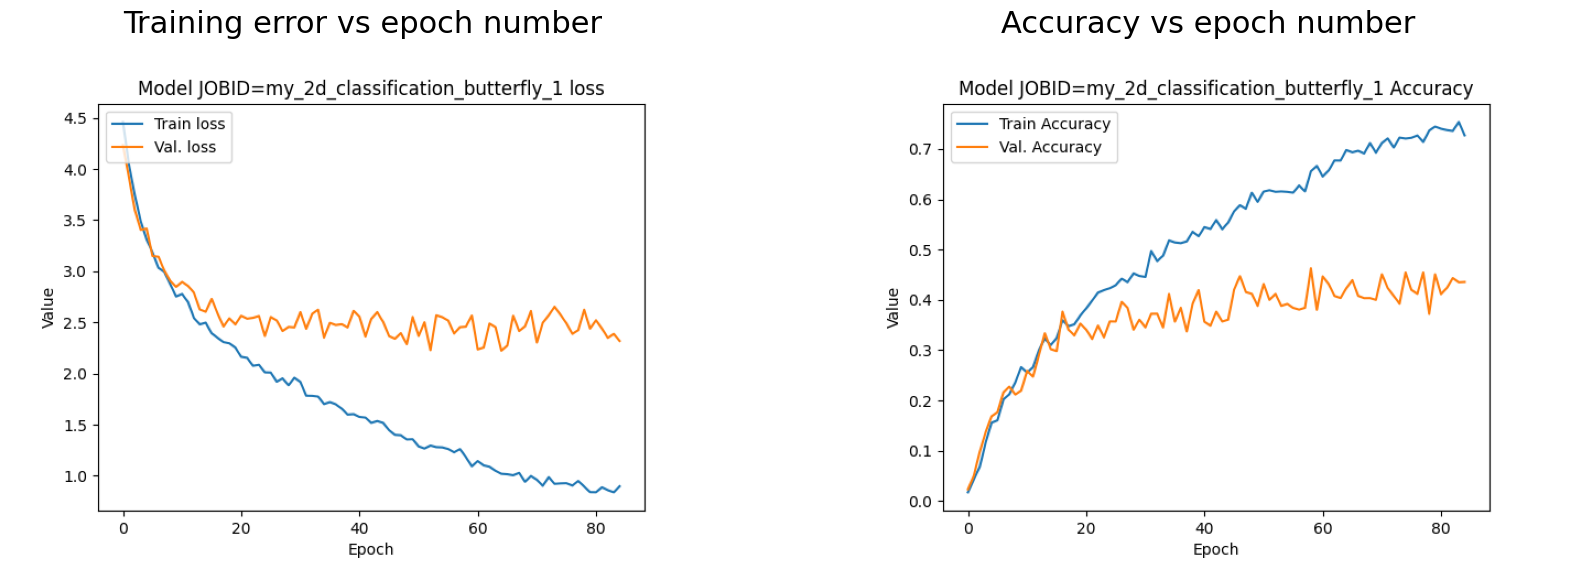

In [8]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and accuracy vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_Accuracy.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Accuracy vs epoch number', fontdict = {'fontsize':22})

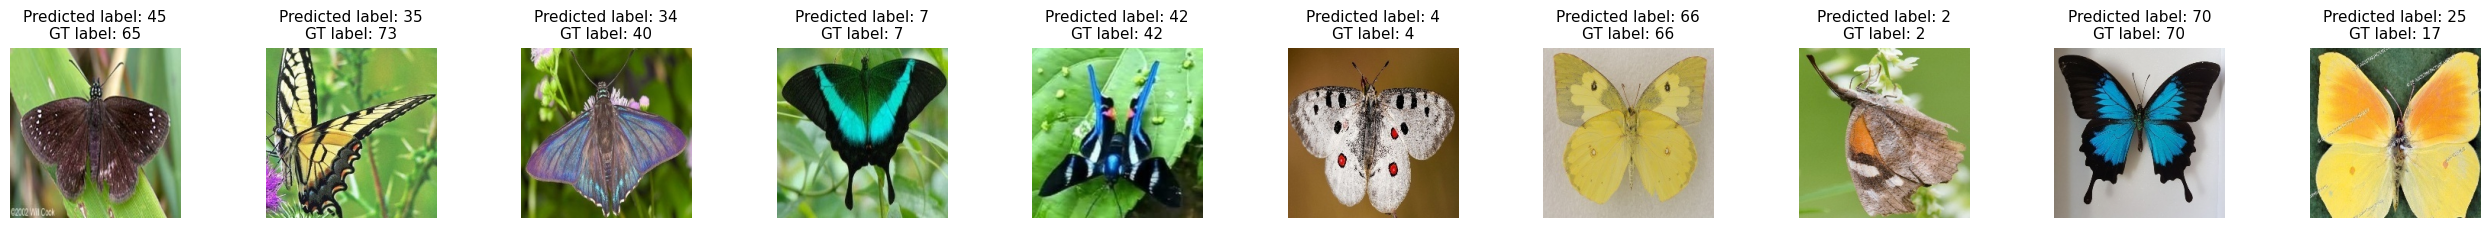

In [9]:
#@markdown ##Visualize predictions

import pandas as pd
import matplotlib.pyplot as plt
import os

predictions_df = pd.read_csv('/content/output/'+str(job_name)+'/results/'+str(job_name)+'_1/predictions.csv')
#labels = sorted([folder for folder in os.listdir(test_data_path) if os.path.isdir(os.path.join(test_data_path, folder))])

# Reading class names dynamically from folder names
labels = sorted([folder for folder in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, folder))])

def find_original_class(filename, labels):
    for index, label in enumerate(labels):
        if filename in os.listdir(os.path.join(test_data_path, label)):
            return index
    return None

def display_predictions(predictions_df, labels, num_image):
    random_samples = predictions_df.sample(n=num_image)
    fig = plt.figure(figsize=(25, 25 * num_image))

    for index, (idx, row) in enumerate(random_samples.iterrows()):
        original_class = find_original_class(row['filename'], labels)
        image_path = os.path.join(test_data_path, labels[original_class], row['filename'])
        image = plt.imread(image_path)

        ax = plt.subplot(1, num_image, index + 1)
        if image.shape[-1] == 1 or image.ndim == 2:
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)

        predicted_label_name = row['class']
        original_label_name = original_class

        if test_ground_truth:
            ax.set_title(f"Predicted label: {predicted_label_name}\nGT label: {original_label_name}", fontsize=11)
        else:
            ax.set_title(f"Predicted label: {predicted_label_name}", fontsize=11)

        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

display_predictions(predictions_df, labels, 10)

In [10]:
#@markdown ###Play to display the path to the output CSV file

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

class_results = os.path.join(final_results, "predictions.csv")

print("Output paths:")
print("    Predicted test classes are in {}".format(class_results))

[06:16:35.309132] Output paths:
[06:16:35.310260]     Predicted test classes are in /content/output/my_2d_classification_butterfly/results/my_2d_classification_butterfly_1/predictions.csv


## **Download classification results**

In [ ]:
#@markdown ###Play to download the CSV file with all classification results in test.

from google.colab import files

files.download(class_results)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Export your model to BioImage Model Zoo format:**

If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [ ]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

# ------------- User input ------------
# information about the model
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "[First Author, Second Author, Third Author]" #@param {type:"string"}
trained_model_authors_affiliation =  "[First Author Affiliation, Second Author Affiliation, Third Author Affiliation]" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = ["Ronneberger et al. arXiv in 2015", "Franco-Barranco, Daniel, et al. ISBI in 2023"] #@param {type:"string"}
trained_model_references_DOI = ["10.1007/978-3-319-24574-4_28","10.1109/ISBI53787.2023.10230593"] #@param {type:"string"}
trained_model_tags = "modality: electron-microscopy, content: mitochondria" #@param {type:"string"}
trained_model_documentation = "/content/README.md" #@param {type:"string"}


In [ ]:
#@markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model
# update BMZ export parameters

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:
    from google.colab import files

    # create the author spec input
    auth_names = trained_model_authors[1:-1].split(",")
    auth_affs = trained_model_authors_affiliation[1:-1].split(",")
    assert len(auth_names) == len(auth_affs)
    authors = [{"name": auth_name, "affiliation": auth_aff} for auth_name, auth_aff in zip(auth_names, auth_affs)]

    # create the citation input spec
    assert len(trained_model_references_DOI) == len(trained_model_references)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(trained_model_references, trained_model_references_DOI)]

    tags = [{t.split(":")[0]: t.split(":")[1]} for t in trained_model_tags.split(",")]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Gizmo"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=[{'modality': 'electron-microscopy', 'content': 'mitochondria'}]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    bmz_cfg['doc'] = trained_model_documentation

    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)

bmz_zip_path = f"/content/{trained_model_name}.bmz.zip"
if os.path.isdir(bmz_results):
    !zip -r $bmz_zip_path $bmz_results
else:
    print("The model was not exported to this format")

files.download(bmz_zip_path)

## **Acknowledgments**
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). In particular, we have reused some of their descriptions of metrics and parameters.